# Emotion AI

## Nutshell

In this project I build a program that classifies emotions from images of human faces, as explained on the course *Modern Artificial Intelligence*, lectured by Dr. Ryan Ahmed, Ph.D. MBA.

The data set I use is from https://www.kaggle.com/c/facial-keypoints-detection/overview and consists of over 20000 facial images that have been labeled with facial expression/emotion and approximately 2000 images with their keypoint annotations.

The program will train two models which will detect
1.   facial keypoints
2.   detect emotions.

Then these models are combined into one model that will provide the keypoints and the emotion as the output.

In [3]:
#HIDE
# @title Loading libraries and setting up drive
%%capture

from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks/Emotion-AI/'

# Import the necessary packages
import io
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback, CSVLogger
from IPython.display import display
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, ZeroPadding2D, BatchNormalization, Activation, Input, Add, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab.patches import cv2_imshow
import copy
from graphviz import Digraph
from IPython.display import Javascript, HTML, Image, display

from PIL import Image as PILImage
import copy
from scipy.ndimage import rotate
import requests

from pathlib import Path
retrain_model = False  # ← Change to True when you want to retrain
rerun_example = False  # ← Change to True when you want to rerun the example
push_git = False # <- Change this to True when you wan to push the changes


image_base = Path('/content/drive/MyDrive/Colab Notebooks/Emotion-AI/docs/pics')

In [4]:
#HIDE
palette = [
    "#c7522a", "#e5c185", "#f0daa5", "#fbf2c4",
    "#b8cdab", "#74a892", "#008585", "#004343"
]
grey = "#e9ecef"
kp_color="#c7522a"
palette_hex = {"InputLayer": "#ffaa00",
    "ZeroPadding2D":"#e9854f",
    "Conv2D": "#8ECAE6",
    "BatchNormalization": "#219EBC",
    "Activation": "#023047",
    "ReLU": "#993461",
    "Add": "#126782",
    "MaxPooling2D": "#f09135",
    "AveragePooling2D": "#f09135",
    "Flatten": "#bd5665",
    "Dense": "#993461",
    "Dropout": "#692161"}

In [5]:
#HIDE
import matplotlib as mpl

grey = "#e9ecef"
legend_bg = "#272b30"

mpl.rcParams.update({
    # text
    "text.color": grey,
    "axes.labelcolor": grey,
    "axes.titlecolor": grey,
    "xtick.color": grey,
    "ytick.color": grey,

    # axes / spines / grid
    "axes.edgecolor": grey,
    "grid.color": grey,

    # legend
    "legend.labelcolor": grey,
    "legend.facecolor": legend_bg,
    "legend.edgecolor": "none",

    # Transparent backgrounds everywhere
    "figure.facecolor": "none",
    "axes.facecolor": "none",
    "savefig.facecolor": "none",
    "savefig.transparent": True,
})


## A short recap of artificial neuronal networks

Artificial neurons are built in a similar way as human neurons. The artificial neurons take in signals through input channels (dendrites in human neurons) and processes information through transfer functions (cell bodies) and generates an output (which would travel through the axon of a neuronal cell).

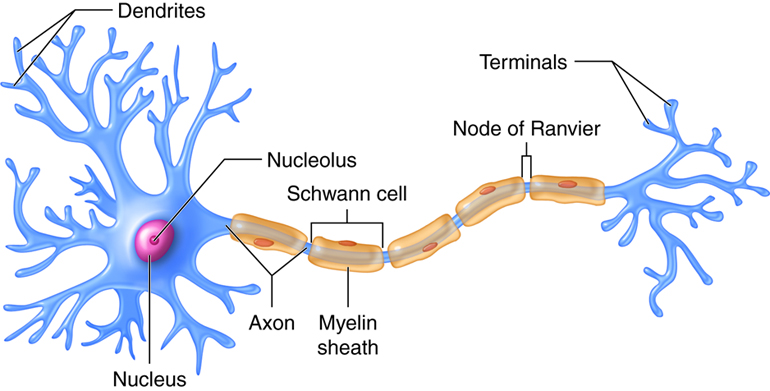

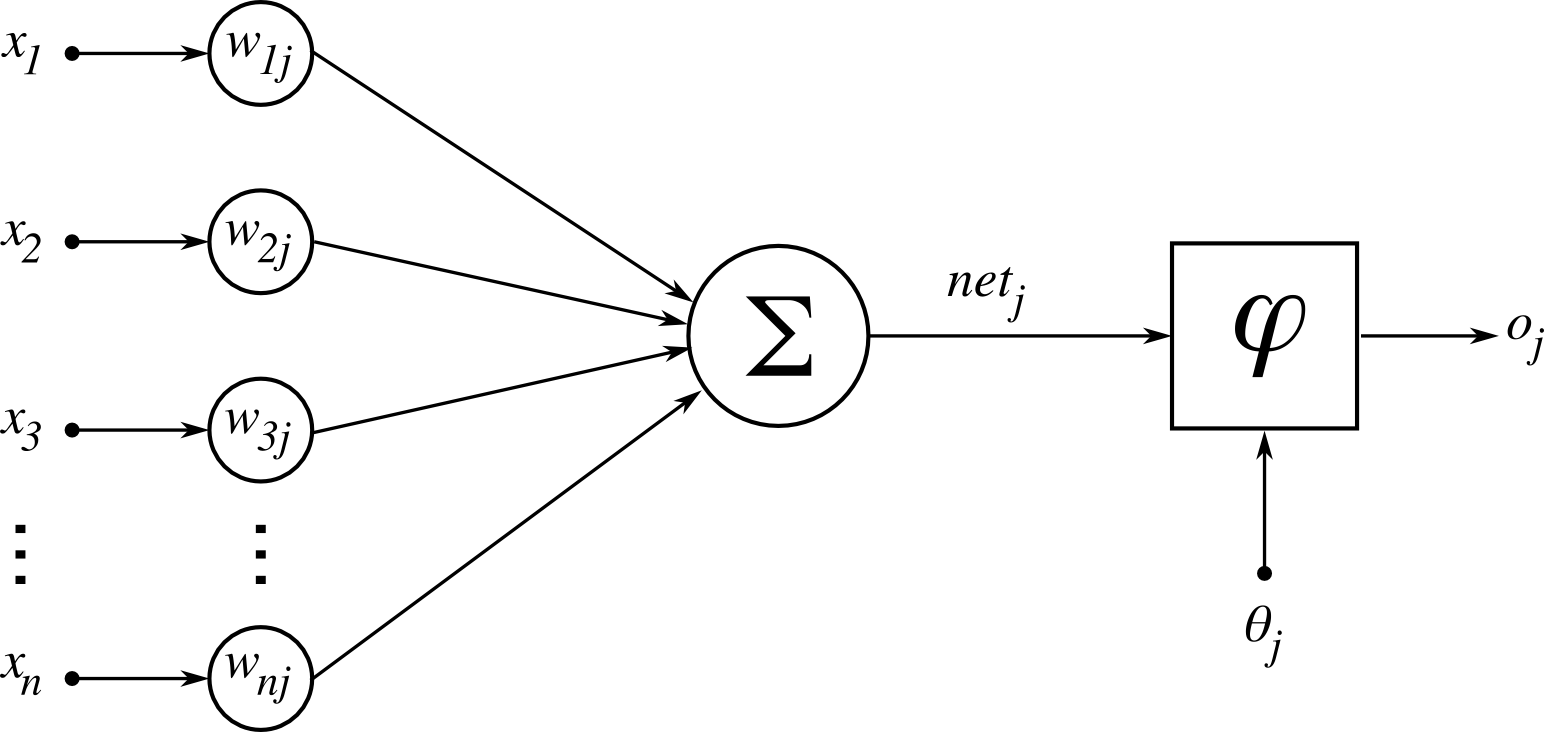

In [4]:
#HIDE
# @title Artificial and biological neuron
display(Image(filename='/content/drive/MyDrive/Colab Notebooks/Emotion-AI/docs/pics/neuron.jpeg', width=500))
#Add a white background to neuron so it is visible on webpage
in_path = image_base/"ArtificialNeuronModel.png"   # your input
out_path = image_base/"ArtificialNeuronModel_whitebg.png"


img = PILImage.open(in_path).convert("RGBA")

white = PILImage.new("RGBA", img.size, (255, 255, 255, 255))
out = PILImage.alpha_composite(white, img).convert("RGB")
out.save(out_path)

display(Image(filename=out_path, width=500))

*Fig. 1*. Side by side view of artificial and biological neurons. Credit: Top image from Introduction to Psychology (A critical approach) Copyright © 2021 by Rose M. Spielman; Kathryn Dumper; William Jenkins; Arlene Lacombe; Marilyn Lovett; and Marion Perlmutter licensed under a Creative Commons Attribution 4.0 International License.
Bottom image [Chrislb, CC BY-SA 3.0 ](http://creativecommons.org/licenses/by-sa/3.0/), via Wikimedia Commons

For example lets consider an artificial neuron (AN) that takes three inputs: $x_1$, $x_2$, and $x_3$. We can then express the output of the artificial neuron mathematically as
$y = \phi(X_1W_1 + X_2W_2 + X_3W_3 + b)$. Here $y$ is the output and the $W$s are the weights assigned to each input signal. $b$ is a bias term added to the weighted sum of inputs. $\phi$ is the activation function.

Some common modern activation functions used in neural networks are for example ReLU, GELU and the logistic activation function. ReLU is short for Rectified linear unit function and is defined as
$\phi(x) = max(0,\alpha + x'b)$. ReLU is recommended for the hidden layers, since it outputs a linear response for positive values. This helps maintain larger gradients and makes training deep networks more feasible.

The Gaussian Error Linear Unit (GELU) is a smoother version of the ReLU and is defined as
$x\phi(x)$, where the $\phi(x)$ stands for Gaussian cumulative distribution function.

The logistic activation function is also called sigmoid function and is defined as
 $\phi(x) = \frac{1}{1+e^{-x}}$. It takes a number and sets it between 0 and 1 and thus is very helpful in output layers.


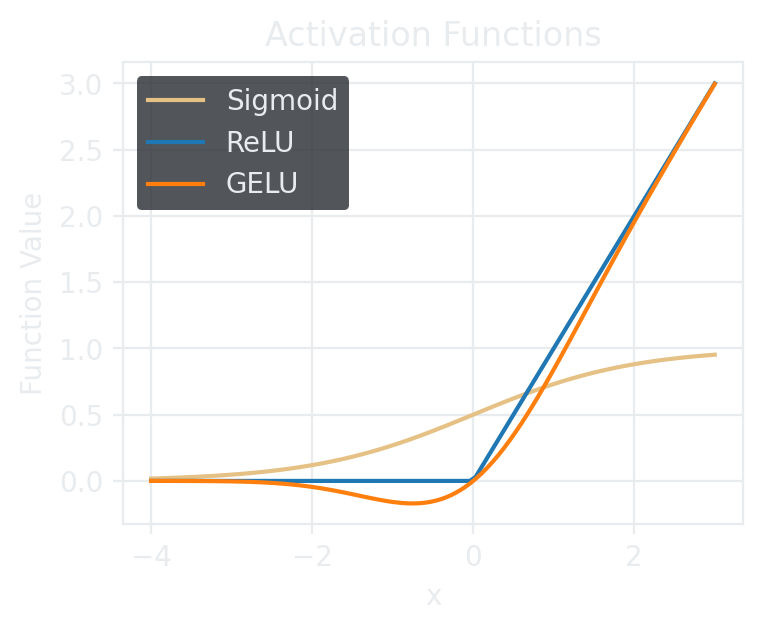

In [64]:
#HIDE
# @title Activation functions
# Display the activation functions
#https://colorkit.co/palette/c7522a-e5c185-f0daa5-fbf2c4-b8cdab-74a892-008585-004343/


def sigmoid(x):
  """Calculates the sigmoid function for a given input."""
  return 1 / (1 + np.exp(-x))

def relu(x):
  """Calculates the ReLU function for a given input."""
  return np.maximum(0, x)

def gelu(x):
  """Calculates the GELU function for a given input (with the approximation)."""
  return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

# Generate x values for the plot
x = np.linspace(-4, 3, 100)  # 100 points between -10 and 10

fig, ax = plt.subplots(figsize=(4, 3))
# Title/labels in grey
ax.set_title("Activation Functions")
ax.set_xlabel("x")
ax.set_ylabel("Function Value")

# Create the plot with a smaller figure size
fig.patch.set_alpha(0)
ax.plot(x, sigmoid(x), label='Sigmoid', color=palette[1])
ax.plot(x, relu(x), label='ReLU')
ax.plot(x, gelu(x), label='GELU')
ax.grid(True)
leg = ax.legend()


out_path = "docs/pics/activation.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
plt.close(fig)

# display smaller in the notebook/html too
display(Image(filename=out_path, width=460))


### Training

All neural networks need to be trained with labeled data. The available data is generally devided to 80% training and 20% testing data. It is also recommended to further divide the training data into an actual training data set (e.g. 60%) and a validation data set (e.g. 20%).

Training is done by adjusting the weights of the network, by iteratively minimising the cost function using for example the gradient descent optimization algorithm. It works by calculating the gradient of the cost function and then takes a step to the negative direction until it reaches the local or global minimum.

A typical choice for a cost function is the quadratic loss, which is formulated as $f_{loss}(w,b)= \frac{1}{N}\sum^n_{i=1}(\hat y-y)$.

Gradient descent algorithm:

  <font color="steelblue"> 1. Calculate the derivative of the loss function</font>
      
  $\frac{\delta f_{loss}}{\delta w}$

  <font color="steelblue">2. Pick random values for weights and substitute.</font>
  
  <font color="steelblue">3. Calculate the step size, i.e. how much we will update our weights.</font>

  step size = learning rate * gradient $=\alpha*\frac{\delta f_{loss}}{\delta w}$
  
  <font color="steelblue">4. Update the parameters and repeat.</font>

  new weight = old weight - step size
  $w_{new}=w_{old}-\alpha*\frac{\delta f_{loss}}{\delta w}$

Below is an example for searching the minimum of a u-shaped funciton with gradient descent. Usually the situation is mulidimensional but the simplification is solved in a similar way.

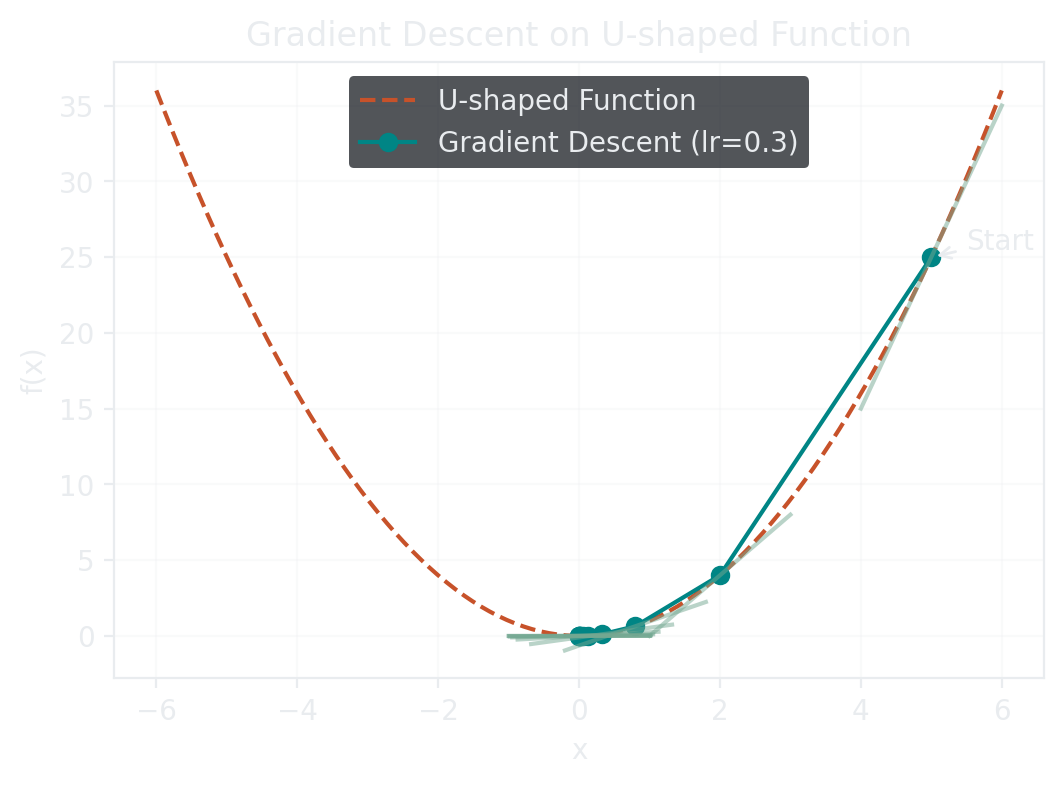

In [6]:
#HIDE
import numpy as np
import matplotlib.pyplot as plt

def u_shaped_function(x):
    return x**2

def gradient(x):
    return 2 * x

def visualize_gradient_descent(learning_rate, iterations, out_path):
    x_start = 5
    x_values = [x_start]
    y_values = [u_shaped_function(x_start)]
    tangents = []

    for i in range(iterations):
        x_current = x_values[-1]
        gradient_current = gradient(x_current)
        x_next = x_current - learning_rate * gradient_current
        x_values.append(x_next)
        y_values.append(u_shaped_function(x_next))

        tangent_x = np.linspace(x_current - 1, x_current + 1, 10)
        tangent_y = u_shaped_function(x_current) + gradient_current * (tangent_x - x_current)
        tangents.append((tangent_x, tangent_y))

    # pick colors
    c_func    = palette[0]                  # dark teal for function
    c_path    = palette[6]  # learning-rate based
    c_tangent = palette[5]                   # teal for tangents

    fig, ax = plt.subplots(figsize=(6, 4))
    x_range = np.linspace(-6, 6, 100)

    ax.plot(x_range, u_shaped_function(x_range), linestyle="--", color=c_func, label="U-shaped Function")
    ax.plot(x_values, y_values, marker="o", color=c_path, label=f"Gradient Descent (lr={learning_rate})")

    for tangent_x, tangent_y in tangents:
        ax.plot(tangent_x, tangent_y, color=c_tangent, alpha=0.5)

    ax.annotate("Start", (x_start, u_shaped_function(x_start)),
                xytext=(x_start + 0.5, u_shaped_function(x_start) + 0.5),
                arrowprops=dict(arrowstyle="->", color=grey),
                color=grey)


    ax.set_title("Gradient Descent on U-shaped Function")
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.grid(True, alpha=0.25)

    leg = ax.legend()

    fig.savefig(out_path, transparent=True, bbox_inches="tight", dpi=200)
    plt.close(fig)
    display(Image(filename=out_path, width=460))

visualize_gradient_descent(learning_rate=0.3, iterations=10, out_path='docs/pics/learning_r1.png')


Testing various learning rates helps undestand the importance of choosing the parameters of training.

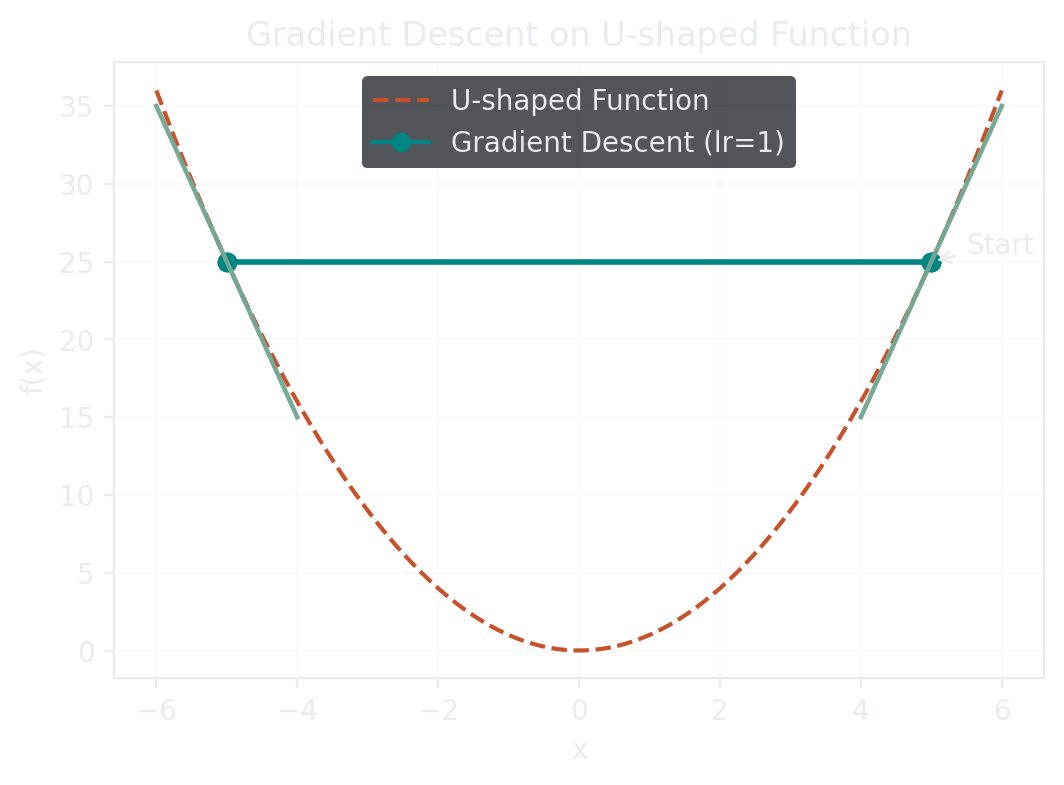

In [53]:
#HIDE
# @title Large learning rate
visualize_gradient_descent(learning_rate=1, iterations=10, out_path='learning_r2.png')

As shown above too large learning rate can lead to missig the global minimum and/or the model does not converge as quickly. Equally problematic can be too small learning rates when the model does not learn. To solve the problems rising from too small or too large learning rates there are several approaches to adjust the learning rates dynamically.

Momentum is analogous to the balls tendency to keep rolling down hill. Momentum is used to speed up the learning when the error cost gradient is heading in the same direction for a long time, and slow down when a leveled area is reached. Momentum is controlled by a variable that is analogous to the mass of the ball rolling. A large momentum helps avoiding getting stuck in local minima, but might also push through the minima we wish to find. Thus, the parameter has to be selected carefully.

Learning rates can also be adjusted through decay, which basically reduces the learning rate by a certain amount after a fixed number of epochs. It can help solve above like situations, where too great learning rate makes the learning jump back and forth over a minimum.

Adagrad or Adam are examples of popular adaptive algorithms for optimising the gradient descent.

### Network architectures

The artificial neurons are connected to each other to form neural networks and a plethora of different network architectures exist. To harness the power of AI, it is necessary to know which architecture serves the intended purpose best. Below are three common architectures and their applications.

Recurrent Neural Networks (RNNs) handle sequential data by maintaining a hidden state that captures information about previous elements in the sequence. Therefore they are great for contexts where the output depends on previous inputs, for example time series and natural language processing.

Generative Adversial Networks (GANs) consist of two neural networks - the Generator and the Discriminator. They sparr each other in a zero-sum game framework, where the genrator creates synthetic data that resembles real data and the discriminator evaluates whether it is rela or not. This dirves the generator to output increasingly realistic data. Obviously, this is the choice for many image generation and editing but also for anomaly detection in industiral and security contexts. GANs can model regular patterns and subsequently detect anomalies by comparing generated outputs with real inputs.

Convolutional Neural Networks (CNN) are designed to process data with a grid-like topology and are most commonly used in image analysis. They utilise convolutional layers to learn spatial hierarchies by applying filters (kernels) that slide (convolve) over the input. They usually involve pooling layers that reduce the spatial dimensions and fully connected layers that map the extracted features to outputs.

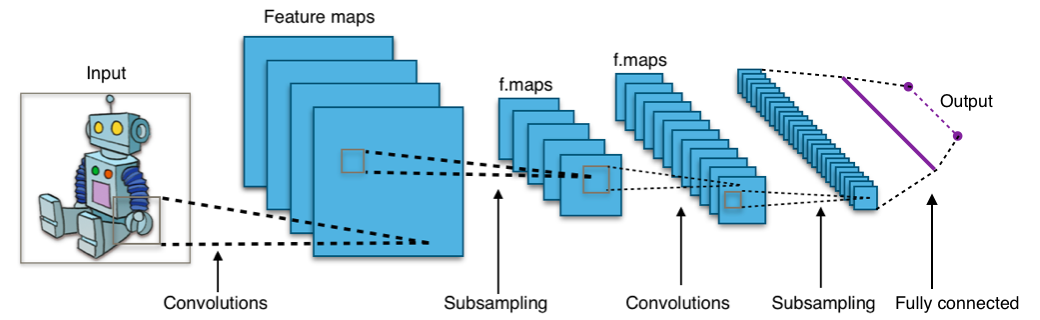

In [ ]:
#HIDE
# @title Convolutional Neural Network
display(Image(filename='/content/drive/MyDrive/Colab Notebooks/Emotion-AI/docs/pics/Typical_cnn.png', width=600))

*Fig. 2.* Convolutional neural network. Credit: [Aphex34, CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0), via Wikimedia Commons

In the Emotion AI, I will use the Residual network (ResNet), which is a Residual Neural Network. Resnet's architecture includes "skip connection" features which enables training very deep networks wihtout vanishing gradient issues. Vanishing gradient problems occurs when the gradient is back-propagated to earlier layers and the resulting gradient is very small.The skip connection feature works by passing the input of one layer to a layer further down in the network. This is also called identity mapping. The ResNet model that I use has been pretrained with the ImagNet dataset.

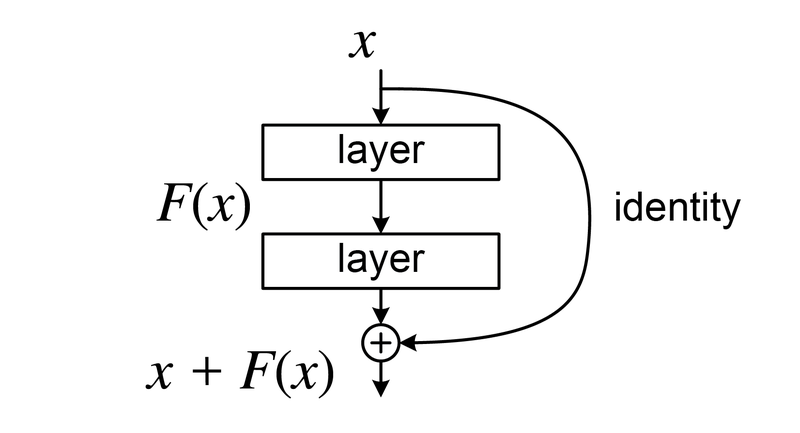

In [ ]:
#HIDE
# @title Skip connection
display(Image(filename='/content/drive/MyDrive/Colab Notebooks/Emotion-AI/docs/pics/ResBlock.png', width=300))

*Fig. 3.* Identity mapping. Credit: [LunarLullaby, CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0), via Wikimedia Commons

# Part 1. Key facial points detection

In this section I program the DL model with convolutional neural network and residual blocks to predict facial keypoints.
The data set is from https://www.kaggle.com/c/facial-keypoints-detection/overview.

The dataset consists of input images with 1**5** facial key points each.
The training.csv file has 7049 face images with corresponding keypoint locations. The test.csv file has face images only, and will be used to test the model. The images are strings of numbers in the shape of (2140,). That has to be transformed into the real shape of the images (96, 96). Thus we create a 1-D array of the string and reshape it to 2D array.

The model I build will have the architecture presented below. The Resblock consists of two different type of blocks: Convolution block and identity block. As seen below, both of them have an additioinal short path to add the original input to the output. For the Covolution block this includes few extra steps to shape the input to the same dimensions as the output from the longer path.


In [6]:
#HIDE
# @title Facial key points detection model architecture
%%capture

#TODO: add adjustable size output

dot = Digraph(comment='Keypoint detection model architecture', format='svg')

# Arrange subgraphs up to down
dot.attr(size='3.5,9',rankdir='UD'
        )
dot.attr('node', shape='box', fontsize='12', margin='0.2,0.2')

###############################################################################
# 1) Subgraph for FINAL MODEL
###############################################################################
with dot.subgraph(name='cluster_final_model') as c:
    c.attr(label='Keypoint model', style='filled', color='lightblue', nodesep='0.3', ranksep='0.3')

    c.node('input', 'INPUT', shape='box')
    c.node('zeropad', 'Zero padding', shape='box')
    c.node('conv2d', 'Conv2D', shape='box')
    c.node('bn_relu', 'BatchNorm, ReLU', shape='box')
    c.node('pool', 'MaxPool2D', shape='box')
    c.node('Res1', 'Res-block', shape='box', style='filled', fillcolor='lightgray')
    c.node('Res2', 'Res-block', shape='box', style='filled', fillcolor='lightgray')
    c.node('Avgpool', 'AveragePooling2D', shape='box')
    c.node('flatten', 'Flatten()', shape='box')
    c.node('dense1', 'Dense, ReLU, Dropout', shape='box')
    c.node('dense2', 'Dense, ReLU, Dropout', shape='box')
    c.node('output', 'OUTPUT', shape='box')

    # Connect them
    c.edge('input', 'zeropad')
    c.edge('zeropad', 'conv2d')
    c.edge('conv2d', 'bn_relu')
    c.edge('bn_relu', 'pool')
    c.edge('pool', 'Res1')
    c.edge('Res1', 'Res2')
    c.edge('Res2', 'Avgpool')
    c.edge('Avgpool', 'flatten')
    c.edge('flatten', 'dense1')
    c.edge('dense1', 'dense2')
    c.edge('dense2', 'output')

###############################################################################
# 2) Subgraph for RES-BLOCK
###############################################################################
with dot.subgraph(name='cluster_resblock') as c:
    # Label and style the subgraph
    c.attr(label='Res-block', style='filled', color='lightgrey',
           nodesep='0.3', ranksep='0.3')

    # Define nodes inside this cluster
    c.node('conv', 'Convolution Block', shape='box',  style='filled', fillcolor='lightpink')
    c.node('id1', 'Identity Block 1', shape='box',  style='filled', fillcolor='lightgreen')
    c.node('id2', 'Identity Block 2', shape='box', style='filled', fillcolor='lightgreen' )

    # Connect them
    c.edge('conv', 'id1')
    c.edge('id1', 'id2')
# Render diagram (outputs two files: .gv source and .svg image)
dot.render('docs/pics/keypoint_model_architecture', view=True)
#dot

In [7]:
#HIDE
# @title Resblock architecture
%%capture
dot = Digraph(comment='Resblock architecture', format='svg')

# Arrange the two blocks:
dot.attr(size='4.5,9', rankdir='TB', splines='ortho', nodesep='0.2', ranksep='0.3')
dot.attr('node', shape='box', fontsize='12', margin='0.2,0.2')

###############################################################################
# 1) Subgraph for CONVOLUTION BLOCK
###############################################################################
with dot.subgraph(name='cluster_convblock') as c:
    # Subgraph label & style
    c.attr(label='Convolution block', style='filled', color='lightpink')

    # Nodes (main path)
    c.node('conv_in', 'INPUT', shape='box', group='leftcol')
    c.node('conv2d1', 'Conv2D', shape='box', group='leftcol')
    c.node('maxpool1', 'MaxPool2D', shape='box', group='leftcol')
    c.node('bn_relu1', 'BatchNorm, ReLU', shape='box', group='leftcol')
    c.node('conv2d2', 'Conv2D (kernel 3×3)', shape='box', group='leftcol')
    c.node('bn_relu2', 'BatchNorm, ReLU', shape='box', group='leftcol')
    c.node('conv2d3', 'Conv2D', shape='box', group='leftcol')
    c.node('bn3', 'BatchNorm', shape='box', group='leftcol')

    # "Add" node, often drawn as a circle with a plus sign
    # (You could also label it "Add" or "Σ", but we'll just do a plus)
    c.node('add_conv', label='+', shape='circle')

    # Final ReLU
    c.node('relu_conv', 'ReLU', shape='box')

    # Main path edges
    c.edge('conv_in', 'conv2d1')
    c.edge('conv2d1', 'maxpool1')
    c.edge('maxpool1', 'bn_relu1')
    c.edge('bn_relu1', 'conv2d2')
    c.edge('conv2d2', 'bn_relu2')
    c.edge('bn_relu2', 'conv2d3')
    c.edge('conv2d3', 'bn3')
    c.edge('bn3', 'add_conv')   # connect final BN to the Add node

    # Short path  nodes
    c.node('conv_short', 'Conv2D', shape='box', group='rightcol')
    c.node('maxpool2', 'MaxPool2D', shape='box', group='rightcol')
    c.node('bn_short', 'BatchNorm', shape='box', group='rightcol')

    # Short path (INPUT -> Add)
    # Optionally style it differently:
    c.edge('conv_in', 'conv_short', style='dashed', color='red')
    c.edge('conv_short', 'maxpool2', style='dashed', color='red')
    c.edge('maxpool2', 'bn_short', style='dashed', color='red')
    c.edge('bn_short', 'add_conv', style='dashed', color='red')

    # Add -> final ReLU
    c.edge('add_conv', 'relu_conv')

###############################################################################
# 2) Subgraph for IDENTITY BLOCK
###############################################################################
with dot.subgraph(name='cluster_idblock') as c:
    c.attr(label='Identity block', style='filled', color='lightgreen')

    # Nodes (main path)
    c.node('id_in', 'INPUT', shape='box', group='leftcol')
    c.node('id_conv1', 'Conv2D', shape='box', group='leftcol')
    c.node('id_bn_relu1', 'BatchNorm, ReLU', shape='box', group='leftcol')
    c.node('id_conv2', 'Conv2D (kernel 3×3)', shape='box', group='leftcol')
    c.node('id_bn_relu2', 'BatchNorm, ReLU', shape='box', group='leftcol')
    c.node('id_conv3', 'Conv2D', shape='box', group='leftcol')
    c.node('id_bn3', 'BatchNorm', shape='box', group='leftcol')

    # Add node + final ReLU
    c.node('add_id', '+', shape='circle')
    c.node('relu_id', 'ReLU', shape='box')

    # Main path edges
    c.edge('id_in', 'id_conv1')
    c.edge('id_conv1', 'id_bn_relu1')
    c.edge('id_bn_relu1', 'id_conv2')
    c.edge('id_conv2', 'id_bn_relu2')
    c.edge('id_bn_relu2', 'id_conv3')
    c.edge('id_conv3', 'id_bn3')
    c.edge('id_bn3', 'add_id')

    # Short path (INPUT -> Add)
    c.edge('id_in', 'add_id', style='dashed', color='red')

    # Add -> final ReLU
    c.edge('add_id', 'relu_id')

# Render diagram
dot.render('docs/pics/resblock_architecture', view=True)
#dot


In [8]:
#HIDE
# @title Displaying the architectures


html_code = """
<style>
  .image-container {
      display: flex;
      flex-wrap: wrap;
      justify-content: center;
      align-items: flex-start;
      max-width: 1000px;
      margin: 0 auto;
      padding: 5px;
      gap: 20px;
  }
  .image-container .final-model {
      flex: 0 1 390px;
      max-width: 390px;
  }
  .image-container .resblock {
      flex: 1 1 500px;
      max-width: 500px;
  }
  .image-container img {
      width: 100%;
      height: auto;
      box-shadow: 0 4px 8px rgba(0,0,0,0.1);
      border-radius: 8px;
  }
  @media (max-width: 600px) {
      .image-container {
          flex-direction: column;
          gap: 10px;
      }
      .image-container .final-model,
      .image-container .resblock {
          flex: 1 1 100%;
          max-width: 100%;
      }
  }
</style>

<div class="image-container">
  <img src="pics/keypoint_model_architecture.svg" alt="Final model architecture" class="final-model">
  <img src="pics/resblock_architecture.svg" alt="Resblock architecture" class="resblock">
</div>
"""
display(HTML(html_code))


In [7]:
#HIDE
# @title Load data

# load facial key points data
key_points_df = pd.read_csv('Data/data.csv')
#key_points_df.info()
# Are there null values?

#key_points_df.isnull().sum()

In [8]:
#HIDE
key_points_df['Image'].shape
key_points_df['Image'][0]
type(key_points_df['Image'][0])

key_points_df['Image'] = key_points_df['Image'].apply(lambda img: np.fromstring(img, dtype = int, sep = ' ').reshape(96,96))
#key_points_df['Image'][0].shape


In [ ]:
#HIDE
key_points_df.describe()

Sanity check for the data by visualising 64 randomly chosen images along with their key facial points.

In [27]:
#HIDE
# @title Checking the data
# Looking at the images

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(15, 15))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()
for i in range(48):
  img_number=np.random.randint(0, 2139)
  ax = axes[i]
  ax.imshow(key_points_df['Image'][img_number],cmap='grey')

  ax.tick_params(colors=grey)
  ax.patch.set_alpha(0)
  #generate a sequence of numbers starting from 1, going up to (but not including) 31, increasing by two at each step
  for j in range(1,31,2):
    #Use .iloc for positional indexing
    ax.plot(key_points_df.iloc[img_number,j-1],key_points_df.iloc[img_number,j],marker='.', color="#c7522a")

# If there are any unused subplots, hide them
for j in range(48, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Optional: Add a main title for the entire figure
fig.suptitle('Samples from Key Points -data set', fontsize=16, y=1.02)  # y parameter adjusts the title position

# Display the plots
out_path='docs/pics/keypoint_sample.png'
fig.savefig(out_path, transparent=True, bbox_inches="tight", dpi=600)
plt.close(fig)
display(Image(filename=out_path, width=600))


Output hidden; open in https://colab.research.google.com to view.

### Image augmentation

Here I create an additional data set where the images are changed slightly to improve the generalisation of the final AI model. The idea is to get more data and more variability in e.g. orientation, lighting conditions, or size of the image. This will reduce the likelihood of overfitting and ensuring that the model learns the meaningful "concepts" of emotion recognition.
I create 4 types of augmented images:
  1. horisontal flipping
  2. randomly increasing brightness
  3. vertical flipping
  4. rotation with random angle


In [9]:
#HIDE
import matplotlib.pyplot as plt

def show_before_after(
    df_before,
    df_after,
    img_idx,
    *,
    n_keypoints=15,          # 15 points -> 30 columns (x1,y1,...)
    cmap="grey",
    kp_color="#c7522a",
    grey="#e9ecef",
    hide_ticks=True,
    out_path=None,
    transparent=True,
    figsize=(7, 7),
    titles=("Original", "Augmented")
):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # style both axes
    for a in axes:
        if hide_ticks:
            a.set_xticks([])
            a.set_yticks([])

    # images
    axes[0].imshow(df_before["Image"][img_idx], cmap=cmap)
    axes[1].imshow(df_after["Image"][img_idx],  cmap=cmap)

    # keypoints (columns 0..(2*n_keypoints-1) assumed to be x,y,x,y,...)
    for j in range(1, 2 * n_keypoints + 1, 2):
        axes[0].plot(df_before.iloc[img_idx, j-1], df_before.iloc[img_idx, j],
                     marker=".", linestyle="None", color=kp_color)
        axes[1].plot(df_after.iloc[img_idx, j-1], df_after.iloc[img_idx, j],
                     marker=".", linestyle="None", color=kp_color)

    # titles (optional)
    if titles:
        axes[0].set_title(titles[0])
        axes[1].set_title(titles[1])

    if out_path:
        fig.savefig(out_path, transparent=transparent, bbox_inches="tight")
        plt.close(fig)
        return out_path
    else:
        plt.show()
        return None


In [10]:
#HIDE
# @title Horisontal flip
# Creating a new copy of the original data set
key_points_df_copy = copy.copy(key_points_df)

# Retrieve the columns in the dataframe except the image
columns = key_points_df_copy.columns[:-1]

# 1. Horizontal flip of the image along y axis
key_points_df_copy['Image'] = key_points_df_copy['Image'].apply(
    lambda img: np.flip(img, axis = 1))

# The y coordinates will stay the same.
# The x coordinates can be derived by extracting x-coordinate form
# the width of the image.

for i in range(len(columns)):
  if i % 2 == 0:
    key_points_df_copy[columns[i]] = key_points_df_copy[columns[i]].apply(lambda x: 96.- float(x))

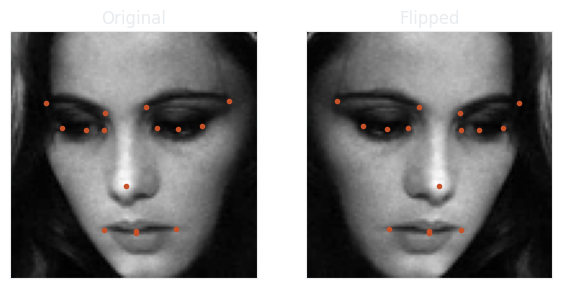

In [11]:
#HIDE
out_path = show_before_after(key_points_df, key_points_df_copy, img_idx=2025,
                             kp_color="#c7522a", grey=grey,
                             out_path="docs/pics/horflip_sample.png",
                             titles=("Original", "Flipped"))
display(Image(filename=out_path))


In [12]:
#HIDE
# Combine the augmented images to the original dataframe
augmented_df = np.concatenate((key_points_df, key_points_df_copy))

In [13]:
#HIDE
# @title Increasing brightness
# 2. Randomly increasing the brightness of images
# multiply pixel values by a random value between 1.5 and 2 to increase brightness
# values allowed are 0-255

key_points_df_copy = copy.copy(key_points_df)
key_points_df_copy['Image'] = key_points_df_copy['Image'].apply(
    lambda img: np.clip(img * np.random.uniform(1.5, 2), 0.0, 255))



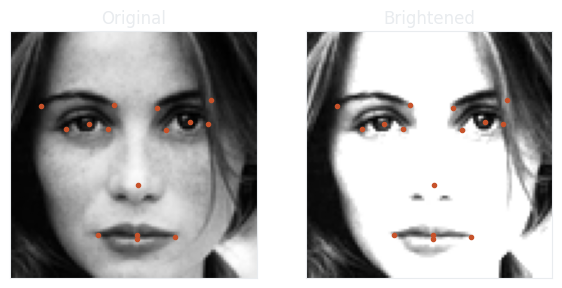

In [14]:
#HIDE
out_path = show_before_after(key_points_df, key_points_df_copy, img_idx=2028,
                  kp_color="#c7522a", grey=grey,out_path="docs/pics/bright_sample.png",
                  titles=("Original", "Brightened"))
display(Image(filename=out_path))

In [15]:
#HIDE
# Combine the augmented images to the original dataframe
augmented_df = np.concatenate((key_points_df, key_points_df_copy))

In [16]:
#HIDE
# @title Vertical flipping
# 3. Vertical fipping of images
key_points_df_copy = copy.copy(key_points_df)

key_points_df_copy['Image'] = key_points_df_copy['Image'].apply(
    lambda img: np.flip(img, axis = 0))

# The x coordinates will stay the same.
# The y coordinates can be derived by extracting x-coordinate form
# the width of the image.

for i in range(len(columns)):
  if i % 2 != 0:
    key_points_df_copy[columns[i]] = key_points_df_copy[columns[i]].apply(lambda y: 96.- float(y))

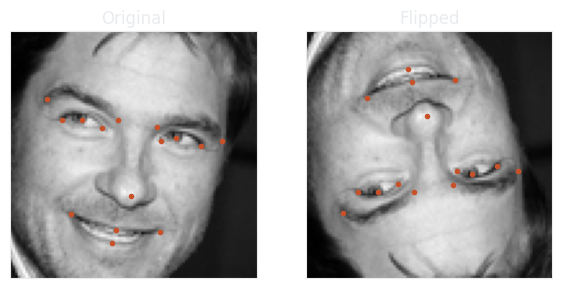

In [17]:
#HIDE
out_path = show_before_after(key_points_df, key_points_df_copy, img_idx=2003,
                  kp_color="#c7522a", grey=grey,out_path="docs/pics/verflip_sample.png",
                  titles=("Original", "Flipped"))
display(Image(filename=out_path))

In [18]:
#HIDE
# Combine the augmented images to the original dataframe
augmented_df = np.concatenate((augmented_df, key_points_df_copy))

In [19]:
#HIDE
# @title Random angle rotation
# ------------------------------------------------------------
#   • key_points_df  – original DataFrame (images + 30 landmark columns)
#   • columns        – landmark column list [x1, y1, x2, y2, …, x15, y15]
#   • augmented_df   – NumPy array already containing the flip-augmented data
# ------------------------------------------------------------

# 1. Image centre (all images are 96 × 96)
h, w = key_points_df['Image'].iloc[0].shape
cx, cy = w / 2, h / 2

# 2. Make a working copy
key_points_df_rot = key_points_df.copy()

# 3. Rotate every row with its *own* random angle 5 – 90 °
for idx in key_points_df_rot.index:
    angle = np.random.randint(5, 80)                 # unique angle
    theta = np.deg2rad(angle)
    cos_t, sin_t = np.cos(theta), np.sin(theta)

    # 3a. rotate the image (negative angle ⇒ correct screen direction)
    img = key_points_df.at[idx, 'Image']
    key_points_df_rot.at[idx, 'Image'] = rotate(
        img, -angle, reshape=False, mode='nearest')

    # 3b. rotate all key-points
    for i in range(0, len(columns), 2):
        xcol, ycol = columns[i], columns[i + 1]
        x = key_points_df.at[idx, xcol]
        y = key_points_df.at[idx, ycol]
        x0, y0 = x - cx, y - cy
        key_points_df_rot.at[idx, xcol] = x0 * cos_t - y0 * sin_t + cx
        key_points_df_rot.at[idx, ycol] = x0 * sin_t + y0 * cos_t + cy


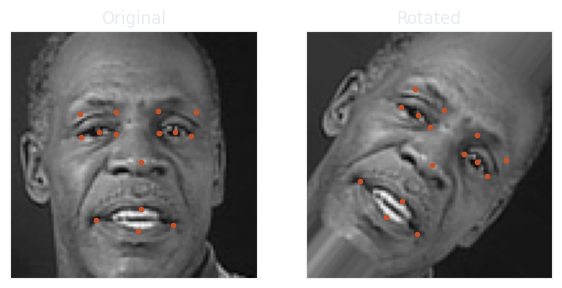

In [20]:
#HIDE
out_path = show_before_after(key_points_df, key_points_df_rot, img_idx=1900,
                  kp_color="#c7522a", grey=grey,out_path="docs/pics/rot_sample.png",
                  titles=("Original", "Rotated"))
display(Image(filename=out_path))

In [21]:
#HIDE
# Combine the augmented images to the original dataframe
augmented_df = np.concatenate((augmented_df, key_points_df_rot), axis=0)
augmented_df.shape

(8560, 31)

### Data normalization and scaling

Normalizing the image pixel values to range 0 - 1:

In [22]:
#HIDE
# @title Data normalization
# Obtain the values of images (in the 31 st column)
img = augmented_df[:, 30]

# Normalize the images
img = img/255

# Initialise an empty array to feed to the model
img_array = np.empty((len(img), 96, 96, 1))

# Add image values to the img_array
for i in range(len(img)):
  img_array[i] = np.expand_dims(img[i], axis=2)


In [23]:
#HIDE
# Obtain the x and y coordinates to be used as target
img_target = augmented_df[:,:30]
img_target = np.asarray(img_target).astype(np.float32)
#img_target.shape

In [24]:
# Split the data into train and test data
X_train_kp, X_test_kp, y_train_kp, y_test_kp = train_test_split(img_array, img_target, test_size=0.2, random_state=42)

In [43]:
#HIDE
X_train_kp.shape

(6848, 96, 96, 1)

In [44]:
#HIDE
X_test_kp.shape

(1712, 96, 96, 1)

In [45]:
#HIDE
y_test_kp.shape

(1712, 30)

In [46]:
#HIDE
y_train_kp.shape

(6848, 30)

## Building the Residual Neural Network model for key facial points detection


Kernels are used to modify the input by sweeping it over the original input as shown in this animation:



In [119]:
#HIDE
# @title 2D Convolution
# To do: explain about kernels. https://commons.wikimedia.org/wiki/File:2D_Convolution_Animation.gif https://towardsdatascience.com/no-kernels-filters-are-not-the-same-b230ec192ac9


html_code = """
<div style="text-align:center;">
  <img src="pics/2D_Convolution_Animation.gif" width="500" alt="2D Convolution Animation">
</div>
"""
display(HTML(html_code))

*Fig. 4* Performing a convolution on 6x6 input with a 3x3 kernel using stride 1x1. Credit: [Michael Plotke, CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0), via Wikimedia Commons.

For example, a 2D convolution command:
```
X = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), kernel_initializer = glorot_uniform(seed=0))(X_input)
```
The above function defines the following:

* use 64 distinct filters (each one is a trainable 7×7 “weight grid”).
* use stride 2x2, i.e., the filter jumps 2 pixels at a time, effectively “skipping” every other location.
* intialise the kernels with glorot_uniform method, aka Xavier uniform initialization. This draws samples from a uniform distribution within a specific range, which will be determined from the number of input and output units.

The section below defines the model architecture using Keras.


In [25]:
#HIDE
# @title Identity block

#This block works but using it will hide the output in the model print
def identity_block(X, filters, stage, block):
  """
  Implementation of the identity block.

  Arguments:
  X -- input tensor
  filters -- tuple/list of integers, the number of filters for each conv layer (f1, f2, f3)
  stage -- integer, used to name the layers
  block -- string, used to name the layers uniquely within a stage

  Returns:
  X -- output of the identity block
  """
  # Unpack the filters
  f1, f2, f3 = filters

  # Save the input value (shortcut path)
  X_shortcut = X

  # First component: Conv2D -> BatchNorm -> ReLU
  X = Conv2D(f1, (1, 1), strides=(1, 1),
            name=str(stage) + block + '_conv_a',
            kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=str(stage) + block + '_bn_a')(X)
  X = Activation('relu')(X)

  # Second component: Conv2D (3x3) -> BatchNorm -> ReLU
  X = Conv2D(f2, (3, 3), strides=(1, 1), padding='same',
            name=str(stage) + block + '_conv_b',
            kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=str(stage) + block + '_bn_b')(X)
  X = Activation('relu')(X)

  # Third component: Conv2D (1x1) -> BatchNorm
  X = Conv2D(f3, (1, 1), strides=(1, 1),
            name=str(stage) + block + '_conv_c',
            kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=str(stage) + block + '_bn_c')(X)

  # Add shortcut value to the main path
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [26]:
# @title Resblock

def res_block(X, filter, stage):
  """
  Implementation of the Resblock.

  Arguments:
  X -- input tensor
  filters -- tuple/list of integers, the number of filters for each conv layer (f1, f2, f3)
  stage -- integer, used to name the layers
  block -- string, used to name the layers uniquely within a stage

  Returns:
  X -- output of the res block
  """
  ### 1: Convolutional block###
  # Make a copy of the input
  X_shortcut = X

  f1, f2, f3 = filter

  # ----Long (main) path-----
  # Conv2d
  X = Conv2D(f1, kernel_size = (1,1), strides = (1,1), name=str(stage)+'convblock'+'_conv_a', \
             kernel_initializer = glorot_uniform(seed=0))(X)
  # MaxPool2D
  X = MaxPool2D(pool_size=(2,2))(X)
  # BatchNorm,ReLU
  X = BatchNormalization(axis = 3, name=str(stage)+'convblock'+'_bn_a')(X)
  X = Activation('relu')(X)

  # Conv2D (kernel 3x3)
  X = Conv2D(f2, kernel_size = (3,3), strides = (1,1), padding = 'same', name=str(stage)+'convblock'+'_conv_b', \
            kernel_initializer = glorot_uniform(seed=0))(X)
  # BatchNorm, ReLU
  X = BatchNormalization(axis = 3, name=str(stage)+'convblock'+'_bn_b')(X)
  X = Activation('relu')(X)

  #Conv2D
  X = Conv2D(f3, kernel_size = (1,1), strides = (1,1), name=str(stage)+'convblock'+'_conv_c', \
             kernel_initializer = glorot_uniform(seed=0))(X)
  #BatchNorm, ReLU
  X = BatchNormalization(axis = 3, name=str(stage)+'convblock'+'_bn_c')(X)


  # ----Short path----

  # Conv2D
  X_shortcut = Conv2D(f3, kernel_size = (1,1), strides = (1,1), name=str(stage)+'convblock'+'_conv_short', \
                      kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
  # MaxPool2D and Batchnorm
  X_shortcut = MaxPool2D(pool_size=(2,2))(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3, name=str(stage)+'convblock'+'_bn_short')(X_shortcut)


  # ----Add Paths together----
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  ### 2: Identity block 1 ###
  # Save the input value (shortcut path)
  X_shortcut = X
  block = 'iden1'
  # First component: Conv2D -> BatchNorm -> ReLU
  X = Conv2D(f1, (1, 1), strides=(1, 1), name=str(stage) + block + '_conv_a', \
             kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=str(stage) + block + '_bn_a')(X)
  X = Activation('relu')(X)

  # Second component: Conv2D (3x3) -> BatchNorm -> ReLU
  X = Conv2D(f2, (3, 3), strides=(1, 1), padding='same', name=str(stage) + block + '_conv_b', \
             kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=str(stage) + block + '_bn_b')(X)
  X = Activation('relu')(X)

  # Third component: Conv2D (1x1) -> BatchNorm
  X = Conv2D(f3, (1, 1), strides=(1, 1), name=str(stage) + block + '_conv_c', \
             kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=str(stage) + block + '_bn_c')(X)

  # Add shortcut value to the main path
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  ### 3: Identity block 2 ###
   # Save the input value (shortcut path)
  X_shortcut = X
  block = 'iden2'
  # First component: Conv2D -> BatchNorm -> ReLU
  X = Conv2D(f1, (1, 1), strides=(1, 1), name=str(stage) + block + '_conv_a', \
             kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=str(stage) + block + '_bn_a')(X)
  X = Activation('relu')(X)

  # Second component: Conv2D (3x3) -> BatchNorm -> ReLU
  X = Conv2D(f2, (3, 3), strides=(1, 1), padding='same', name=str(stage) + block + '_conv_b', \
             kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=str(stage) + block + '_bn_b')(X)
  X = Activation('relu')(X)

  # Third component: Conv2D (1x1) -> BatchNorm
  X = Conv2D(f3, (1, 1), strides=(1, 1), name=str(stage) + block + '_conv_c', \
             kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=str(stage) + block + '_bn_c')(X)

  # Add shortcut value to the main path
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

Next build the final model.

In [27]:
# @title Final Resnet Neural Network model

input_shape = (96,96,1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# Stage 1
X = Conv2D(filters = 64, kernel_size = (7,7), strides = (2,2), name='conv1', \
           kernel_initializer = glorot_uniform(seed=0))(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides = (2,2))(X)

# Stage 2
X = res_block(X, filter =  [64, 64, 256], stage = 'res1')

# Stage 3
X = res_block(X, filter = [128,128,512], stage = 'res2')

# We could also add more resblocks if we want
# X = res_block(X, filter= [256,256,1024], stage= 'res3')

# Average pooling
X = AveragePooling2D((2,2), name = 'avg_pool')(X)

# Flatten
X = Flatten()(X)

# Dense, ReLU, Dropout
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)

model_1_facialKeyPoints = Model(inputs = X_input, outputs = X)

In [29]:
#HIDE
# @title Helper function for plotting the architecture
!apt-get -qq install -y graphviz
!pip -q install pydot

import re
import subprocess
from pathlib import Path
from typing import Dict, Optional, Tuple, List

from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG, display

def export_colored_model_graph(
    model,
    image_base,
    stem: str = "model_arch",
    palette_hex: Optional[List[str]] = None,
    type_color_map: Optional[Dict[str, str]] = None,
    show_shapes: bool = True,
    show_layer_names: bool = True,
    rankdir: str = "TB",
    size: str = "30,18",
    nodesep: str = "0.15",
    ranksep: str = "0.25",
    splines: str = "polyline",
    edge_color: str = "#000000",
    node_border_color: str = "#202020",
    bg_color: str = "white",
    border_width: int = 1,
    display_svg: bool = True,
    return_mapping: bool = True,
) -> Tuple[Path, Path, Path, Optional[Dict[str, str]]]:
    """
    Exports a Keras model graph with colored nodes (stable by layer TYPE in parentheses).
    - Stable mapping: alphabetical layer types -> palette cycle (or use type_color_map to pin types).
    - Fixes Keras HTML labels by rewriting bgcolor/font only where needed.
    - Forces consistent border color via <table color="..."> (does NOT override font colors).
    - Forces all graph edges to edge_color.
    """

    if palette_hex is None:
        palette_hex = ["#8ecae6","#219ebc","#126782","#023047","#ffb703","#fd9e02","#fb8500"]

    out_dir = Path(image_base).resolve()
    out_dir.mkdir(parents=True, exist_ok=True)

    dot_path = out_dir / f"{stem}.dot"
    svg_path = out_dir / f"{stem}.svg"
    png_path = out_dir / f"{stem}.png"

    dot = model_to_dot(
        model,
        show_shapes=show_shapes,
        show_layer_names=show_layer_names,
        rankdir=rankdir,
        expand_nested=False,
    )

    dot.set_graph_defaults(
        splines=splines,
        outputorder="edgesfirst",
        concentrate="false",
        ranksep=ranksep,
        nodesep=nodesep,
        pad="0.2",
        margin="0.2",
        ratio="compress",
        size=size,
    )

    # Node border set here is mostly irrelevant (HTML label draws the box),
    # but doesn't hurt:
    dot.set_node_defaults(fontsize="8", margin="0.02", penwidth=str(max(1, border_width)))

    # Make ALL edges black (and enforce again below on each edge)
    dot.set_edge_defaults(arrowsize="0.4", penwidth="1.1", color=edge_color)

    # ---- helpers ----
    def hex_luma(h):
        h = h.lstrip("#")
        r, g, b = int(h[0:2], 16)/255, int(h[2:4], 16)/255, int(h[4:6], 16)/255
        return 0.2126*r + 0.7152*g + 0.0722*b

    def best_text_color(fill_hex):
        return "white" if hex_luma(fill_hex) < 0.55 else "black"

    # Keras label contains: "<b>layer_name</b> (LayerType)"
    rx = re.compile(r"<b>(?P<lname>[^<]+)</b>\s*\((?P<ltype>[^)]+)\)")

    # Collect all types present
    types_found = []
    for node in dot.get_nodes():
        lab = node.get("label")
        if not lab:
            continue
        m = rx.search(lab)
        if m:
            types_found.append(m.group("ltype"))
    types_found = sorted(set(types_found))

    # Stable mapping type->color
    if type_color_map is not None:
        type_to_color = dict(type_color_map)
        remaining = [t for t in types_found if t not in type_to_color]
        for i, t in enumerate(remaining):
            type_to_color[t] = palette_hex[i % len(palette_hex)]
    else:
        type_to_color = {t: palette_hex[i % len(palette_hex)] for i, t in enumerate(types_found)}

    def _fix_table_tag(table_tag: str) -> str:
        """Ensure the <table ...> has consistent border/grid color and border widths."""
        tag = table_tag

        # Force border + cellborder to be present and consistent
        if re.search(r'\bborder="', tag):
            tag = re.sub(r'\bborder="[^"]*"', f'border="{border_width}"', tag)
        else:
            tag = tag[:-1] + f' border="{border_width}">'

        if re.search(r'\bcellborder="', tag):
            tag = re.sub(r'\bcellborder="[^"]*"', f'cellborder="{border_width}"', tag)
        else:
            tag = tag[:-1] + f' cellborder="{border_width}">'

        # Force table border/grid color (THIS affects table lines, not text fonts)
        if re.search(r'\bcolor="', tag):
            tag = re.sub(r'\bcolor="[^"]*"', f'color="{node_border_color}"', tag)
        else:
            tag = tag[:-1] + f' color="{node_border_color}">'

        return tag

    def recolor_html_label(label: str, header_fill: str) -> str:
        """
        Rewrite Keras HTML label:
        - Replace ALL bgcolor="black" -> bgcolor=bg_color (so no leftover black fills)
        - Recolor ONLY the header cell background
        - Set ONLY the header font color for contrast
        - Force ONLY the table border/grid color (via <table color="...">)
        """
        # 1) Remove all black cell fills (Keras uses black by default)
        lab2 = label.replace('bgcolor="black"', f'bgcolor="{bg_color}"')

        # 2) Recolor header cell background (the td with colspan="2")
        lab2 = re.sub(
            r'(<td[^>]*colspan="2"[^>]*bgcolor=")([^"]*)(")',
            rf'\1{header_fill}\3',
            lab2,
            count=1
        )

        # 3) Set ONLY the header font color (first <font ... color="..."> is usually header)
        header_text = best_text_color(header_fill)
        lab2 = re.sub(
            r'(<font[^>]*color=")([^"]+)(")',
            rf'\1{header_text}\3',
            lab2,
            count=1
        )

        # 4) Force consistent table border/grid styling by editing only the <table ...> tag
        lab2 = re.sub(
            r"<table[^>]*>",
            lambda m: _fix_table_tag(m.group(0)),
            lab2,
            count=1
        )

        return lab2

    # Apply node label rewrites
    for node in dot.get_nodes():
        lab = node.get("label")
        if not lab:
            continue
        m = rx.search(lab)
        if not m:
            continue

        ltype = m.group("ltype")
        fill = type_to_color.get(ltype, palette_hex[0])

        node.set_style("filled,rounded")
        node.set_shape("box")
        node.set_color(node_border_color)  # outer node outline (if used)
        node.set_fontcolor(node_border_color)

        node.set("label", recolor_html_label(lab, fill))

    # Enforce all existing edges black as well
    for e in dot.get_edges():
        e.set_color(edge_color)

    # Write DOT
    dot_path.write_text(dot.to_string())

    # Render with cairo to avoid cropped SVG
    tmp_svg = out_dir / f"{stem}__tmp.svg"
    tmp_png = out_dir / f"{stem}__tmp.png"
    if tmp_svg.exists(): tmp_svg.unlink()
    if tmp_png.exists(): tmp_png.unlink()

    res = subprocess.run(["dot", "-Tsvg:cairo", str(dot_path), "-o", str(tmp_svg)],
                         capture_output=True, text=True)
    if res.returncode != 0:
        raise RuntimeError(f"Graphviz SVG render failed:\n{res.stderr}")

    subprocess.check_call(["dot", "-Tpng", str(dot_path), "-o", str(tmp_png)])

    tmp_svg.replace(svg_path)
    tmp_png.replace(png_path)

    if display_svg:
        svg_text = svg_path.read_text(encoding="utf-8")
    display(HTML(f"""
    <style>
    .svg-scroll {{
      max-width: 100%;
      overflow-x: auto;
      overflow-y: hidden;
      -webkit-overflow-scrolling: touch;
      touch-action: pan-x;
    }}
    .svg-scroll .inner {{
      width: max-content;          /* makes content keep its intrinsic width */
    }}
    .svg-scroll svg {{
      max-width: none !important;  /* prevents “shrink-to-fit” */
      height: auto !important;
      display: block;
    }}
    </style>

    <div class="svg-scroll">
      <div class="inner">
        {svg_text}
      </div>
    </div>
    """))
    return dot_path, svg_path, png_path, (type_to_color if return_mapping else None)



In [30]:
#HIDE
# -----------------------------
# Full model
# -----------------------------
dot_path, svg_path, png_path, type_to_color = export_colored_model_graph(
    model=model_1_facialKeyPoints,
    image_base=image_base,
    stem="model_arch",
    type_color_map= palette_hex,
    show_shapes=True,
    rankdir="TB",
    edge_color="#8ECAE6",
    bg_color="white",
    border_width=1,
    display_svg=True,
)


### Explanations of components

The Zeropadding adds a border of zeros (3 pixels wide) around the input image. This will prevent information loss at the edges of convolutions.

Conv2D is the cake of the convolutional layer. It applies the filters to the input image and slides them with a set stride. This way the features are extracted from the image.

The BatchNormalisation layer normalizes the output of the convolution, making training more stable. We can say it is the smooth cream layer on our convolution cake.

The ReLU activation function introduces non-linearity to the model.

MaxpPooling2D reduces the spatial dimensions of the feature maps by taking the maximum value in a window and so downsamples the output.  After the Resblock, AveragePooling2D is used similar to MaxPooling, except it calculates the average value within the window. It also reduces the size of the feature maps. Just to give an impression of the impact of pooling, if we removed the MaxPooling 2D layers from Resblocks the final model would have 256 million parameters - instead of 18 million.

Flatten converts the multi-dimensional feature maps into a single, long vector, preparing the data for the fully connected layers.

Dense creates a fully connected layer where each neuron is connected to every neuron in the previous layer. These fully connected layers will process the features exrtacted by the convolutional layers.

Dropout layers are a regularisation technique which drops a set percentage of the neurons during training by setting them to zero. This makes the model less likely to overfit, and decreases the interdependency between the neurons. Therefore we improve the performance of the network and the generalisability of the model.

The final model has a very complex structure, 18 million trainable parameters, which allows it to learn to identify emotions as good or even better than average human. However, too many parameters can lead to problems, such as overfitting and slow or nonconverging training. Optimising this many parameters is not a trivial task.

## Compiling and training the model

I will use the [Adam optimization](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) method for the training. Adam is a computationally efficient stochastic gradient method and it combines the gradient descent with momentum and the RMSP algorithm.

As discussed earlier, the momentum speeds the training by accelerating the gradients by adding a fraction of the previous gradient to the current one. The RMSP or Root Mean Square Propagation is an adaptive learning algorithm that takes the 'exponential moving average' of the gradients. In other words, it adapts the learning rate for each parameter by keeping track of an exponentially decaying average of past squared gradients.

The algortihm will proceed as follows:

<font color="steelblue">1. Calculate the gradient $g_t$</font>

  $g_t =  \frac{\delta L }{\delta w_t}$

<font color="steelblue">2. Update the Biased first moment estimate $m_t$</font>

  $m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t$

  This is similar to calculating the momentum as we keep track of the decaying average of past gradients.

<font color="steelblue">3. Update the Biased Second Moment Estimate $v_t$</font>

  $v_t = \beta_2 v_{t-1} + (1-\beta_2)g_t^2$

  This is similar to RMSP as we keep track of an exponentially decaying average of past squared gradients.

<font color="steelblue">4. Bias correction for $m_t$ and $v_t$</font>

  Especially at the beginning of training, $m_t$ and $v_t$ are biased toward zero (because the y are initialised at zero). This is corrected by Adam like this:

  $\hat m = \frac{m_t}{1-\beta_1^t}$, $\hat v = \frac{v_t}{1-\beta_2^t}$

<font color="steelblue">5. Parameter update

$w_{t} = w_{t_1} - \alpha_t\frac{\hat m_t}{(v_t+\epsilon)^{1/2}}*g_t$

where,

$g_t$ = gradient of the loss with respect to the parameters at iteration $t$

$\alpha_t$ = learning rate at iteration $t$

$\beta_1, \beta_2$ =  decay rates for the moment estimates

$\epsilon$ = small constant to prevent division by zero

The tensorflow tool for Adam optimization accepts several arguments as input:

<font color="#ffaa00">learning_rate</font>: can be a float or a scheduler that optimizes the learning rate

<font color="#ffaa00">beta_1</font> = A value or constant tensor (float) that tells the exponential decay rate for the 1st moment estimates, i.e. the means of the gradients. Default = 0.9.

<font color="#ffaa00">beta_2</font> = A value or constant tensor (float) that tells the exponential decay rate for the 2nd moment estimates, i.e. the uncentered variance of the squared gradients. Default 0.999.

<font color="#ffaa00">amsgrad</font> = True/False. Wether the AMSGrad variant of the algorithm presented in the paper *On the Convergence of Adam and beyond* shall be applied. Default = False.

<font color="#ffaa00">weight_decay</font> = If set the weight decay will be set.

### Other things to consider when optimising
The batch size determines how many training examples are processed before the model's internal parameters are updated. Smaller batch sizes can speed up the training per epoch because the model updates more frequently. However, this can lead to less stable convergence, i.e. the training loss may fluctuate more. A small batch size can be beneficial in case the model is overfitting (the trianing loss is significantly lower than the validation loss).

A larger batch size leads to slower training per epoch and requires moe memory, but can yield more stable updates for the parameters. The model usually converges more smoothly, but might not generalise as well due to "sharp minima".

Another way to tune the parameters of optimization is to use learning rate schedulers. Why? As training progresses, the model gets closer to a good solution. Smaller learning rates allow for finer adjustments to the model's weights, helping it converge to a better minimum without overshooting (see the gradient descent examples in the beginning). I have implemented a learning rate algorithm that reduces the learning rate if the validation loss does not improve in 5 epochs.

After training, the model is saved in a .keras file. The .keras is a zip archive that contains:
* The architecture
* The weights
* The optimizer's status


In [53]:
# @title Compiling and training with 3 epochs
run_example = True
if run_example:
  adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, \
                                  beta_2 = 0.999, amsgrad = False)
  model_3_facialKeyPoints = Model(inputs = X_input, outputs = X)
  model_3_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam, \
                                  metrics = ['accuracy'])

  #Save the best model with least validation loss here
  checkpoint  = ModelCheckpoint(filepath = "Models/FacialKeyPoints_model_16-12-2025.keras", \
                                verbose = 1, save_best_only = True)

  history3 = model_3_facialKeyPoints.fit(X_train_kp, y_train_kp, batch_size = 32, \
                    epochs = 3, validation_split = 0.05, callbacks=[checkpoint])


Epoch 1/3
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5066 - loss: 511.2633
Epoch 1: val_loss improved from inf to 694.32581, saving model to Models/FacialKeyPoints_model_16-12-2025.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 54s 128ms/step - accuracy: 0.5069 - loss: 509.7457 - val_accuracy: 0.5627 - val_loss: 694.3258
Epoch 2/3
202/204 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6501 - loss: 27.1448
Epoch 2: val_loss improved from 694.32581 to 131.69623, saving model to Models/FacialKeyPoints_model_16-12-2025.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6502 - loss: 27.1052 - val_accuracy: 0.5860 - val_loss: 131.6962
Epoch 3/3
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6906 - loss: 18.1163
Epoch 3: val_loss improved from 131.69623 to 27.90438, saving model to Models/FacialKeyPoints_model_16-12-2025.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6906 - loss: 18.1128 - val_accuracy: 0.7697 - val_loss: 27.9044


In [32]:
#HIDE
# Plot the training history
run_example = False
if run_example:
  plt.plot(history3.history['loss'])
  plt.plot(history3.history['val_loss'])
  plt.title('Keypoint Detection Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train_loss','val_loss'], loc = 'upper right')
else:
  display(Image(filename='/content/drive/MyDrive/Colab Notebooks/Emotion-AI/docs/pics/Training_3epo.png', width=600))


In [55]:
#HIDE
# @title Compiling and training with batch_size = 64, epochs = 100, and decay on plateu of the learning rate
retrain_model = True
if retrain_model:

  initial_learning_rate=0.0008

  # compile model
  adam = tf.keras.optimizers.Adam(learning_rate = initial_learning_rate, beta_1 = 0.9, \
                                  beta_2 = 0.999, amsgrad = False)
  model_1_facialKeyPoints = Model(inputs = X_input, outputs = X)
  model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam, \
                                  metrics = ['accuracy'])
  # Callbacks: reduce lr on plateau
  reduce_lr = ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.65,
      patience=5,
      min_lr=1e-8,
      verbose=1
  )

  early = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True,
    verbose=1,
    mode = 'min'
  )


  # Callbacks: save best model
  checkpoint = ModelCheckpoint(
      filepath="Models/FacialKeyPoints_model_16-12-2025.keras",
      verbose=1,
      save_best_only=True
  )

  # Callbacks: logs epoch results to CSV
  csv_logger = CSVLogger(
      'Models/training_history_model_1.csv',
      append=True,         # keep adding if file exists
      separator=','        # comma-separated
  )
  # fit with CSVLogger included
  history = model_1_facialKeyPoints.fit(
      X_train_kp, y_train_kp,
      batch_size=64,
      epochs=100,
      validation_split=0.05,
      callbacks=[checkpoint, reduce_lr, csv_logger, early]
  )

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5404 - loss: 895.0652
Epoch 1: val_loss improved from inf to 84.35088, saving model to Models/FacialKeyPoints_model_16-12-2025.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 223ms/step - accuracy: 0.5409 - loss: 889.3439 - val_accuracy: 0.6822 - val_loss: 84.3509 - learning_rate: 8.0000e-04
Epoch 2/100
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6552 - loss: 24.0586
Epoch 2: val_loss improved from 84.35088 to 26.11082, saving model to Models/FacialKeyPoints_model_16-12-2025.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6558 - loss: 24.0017 - val_accuracy: 0.7784 - val_loss: 26.1108 - learning_rate: 8.0000e-04
Epoch 3/100
100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6976 - loss: 17.8676
Epoch 3: val_loss improved from 26.11082 to 10.68048, saving model to Models/FacialKeyPoints_model_16-12-2025.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6978 - loss: 17.8524 - val_accura

In [ ]:
#HIDE
print(X_train_kp.shape)   # e.g. (N, 96, 96, 1)
print(y_train_kp.shape)   # should print (N, 30)$

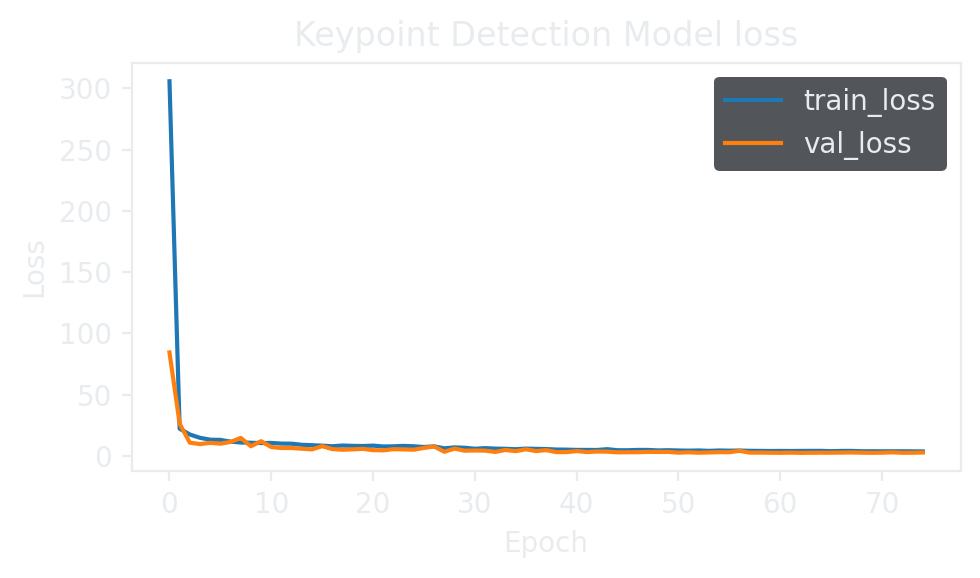

In [46]:
#HIDE
# Plot the training history of 80 epochs

out_path = "docs/pics/kp_train_history.png"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
retrain_model=False
# ---- get history data (either from training or from csv) ----
if not retrain_model:
    df_his = pd.read_csv("Models/training_history_keypoint_16-12-2025.csv", sep=None, engine="python")
    df_his = df_his.apply(pd.to_numeric, errors="coerce")
    history_data = df_his.to_dict(orient="list")
else:
    history_data = history.history  # Keras History object

# ---- plot ----
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(history_data["loss"], label="train_loss")
if "val_loss" in history_data and history_data["val_loss"] is not None:
    ax.plot(history_data["val_loss"], label="val_loss")

ax.set_title("Keypoint Detection Model loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend(loc="upper right")

fig.tight_layout()
fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
plt.close(fig)

display(Image(filename=out_path))

## Assessing the trained key facial points detection model performance



In [34]:
#HIDE
# load the model architecture f = final
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, \
                                beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints = tf.keras.models.load_model("Models/FacialKeyPoints_model_16-12-2025.keras")
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam, \
                                metrics = ['accuracy'])

In [35]:
# Evaluate the model
# The model from materials has loss: 8.3705 accuracy: 0.85280377 with the X_test,y_test set.

result = model_1_facialKeyPoints.evaluate(X_test_kp, y_test_kp)

54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.8771 - loss: 2.5321


In [36]:
#HIDE
# Plotting the test images and their predicted keypoints and emotions

predicted_kp = model_1_facialKeyPoints.predict(X_test_kp)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


In [37]:
#HIDE
predicted_kp = pd.DataFrame(predicted_kp, columns=columns)

In [64]:
#HIDE
predicted_kp

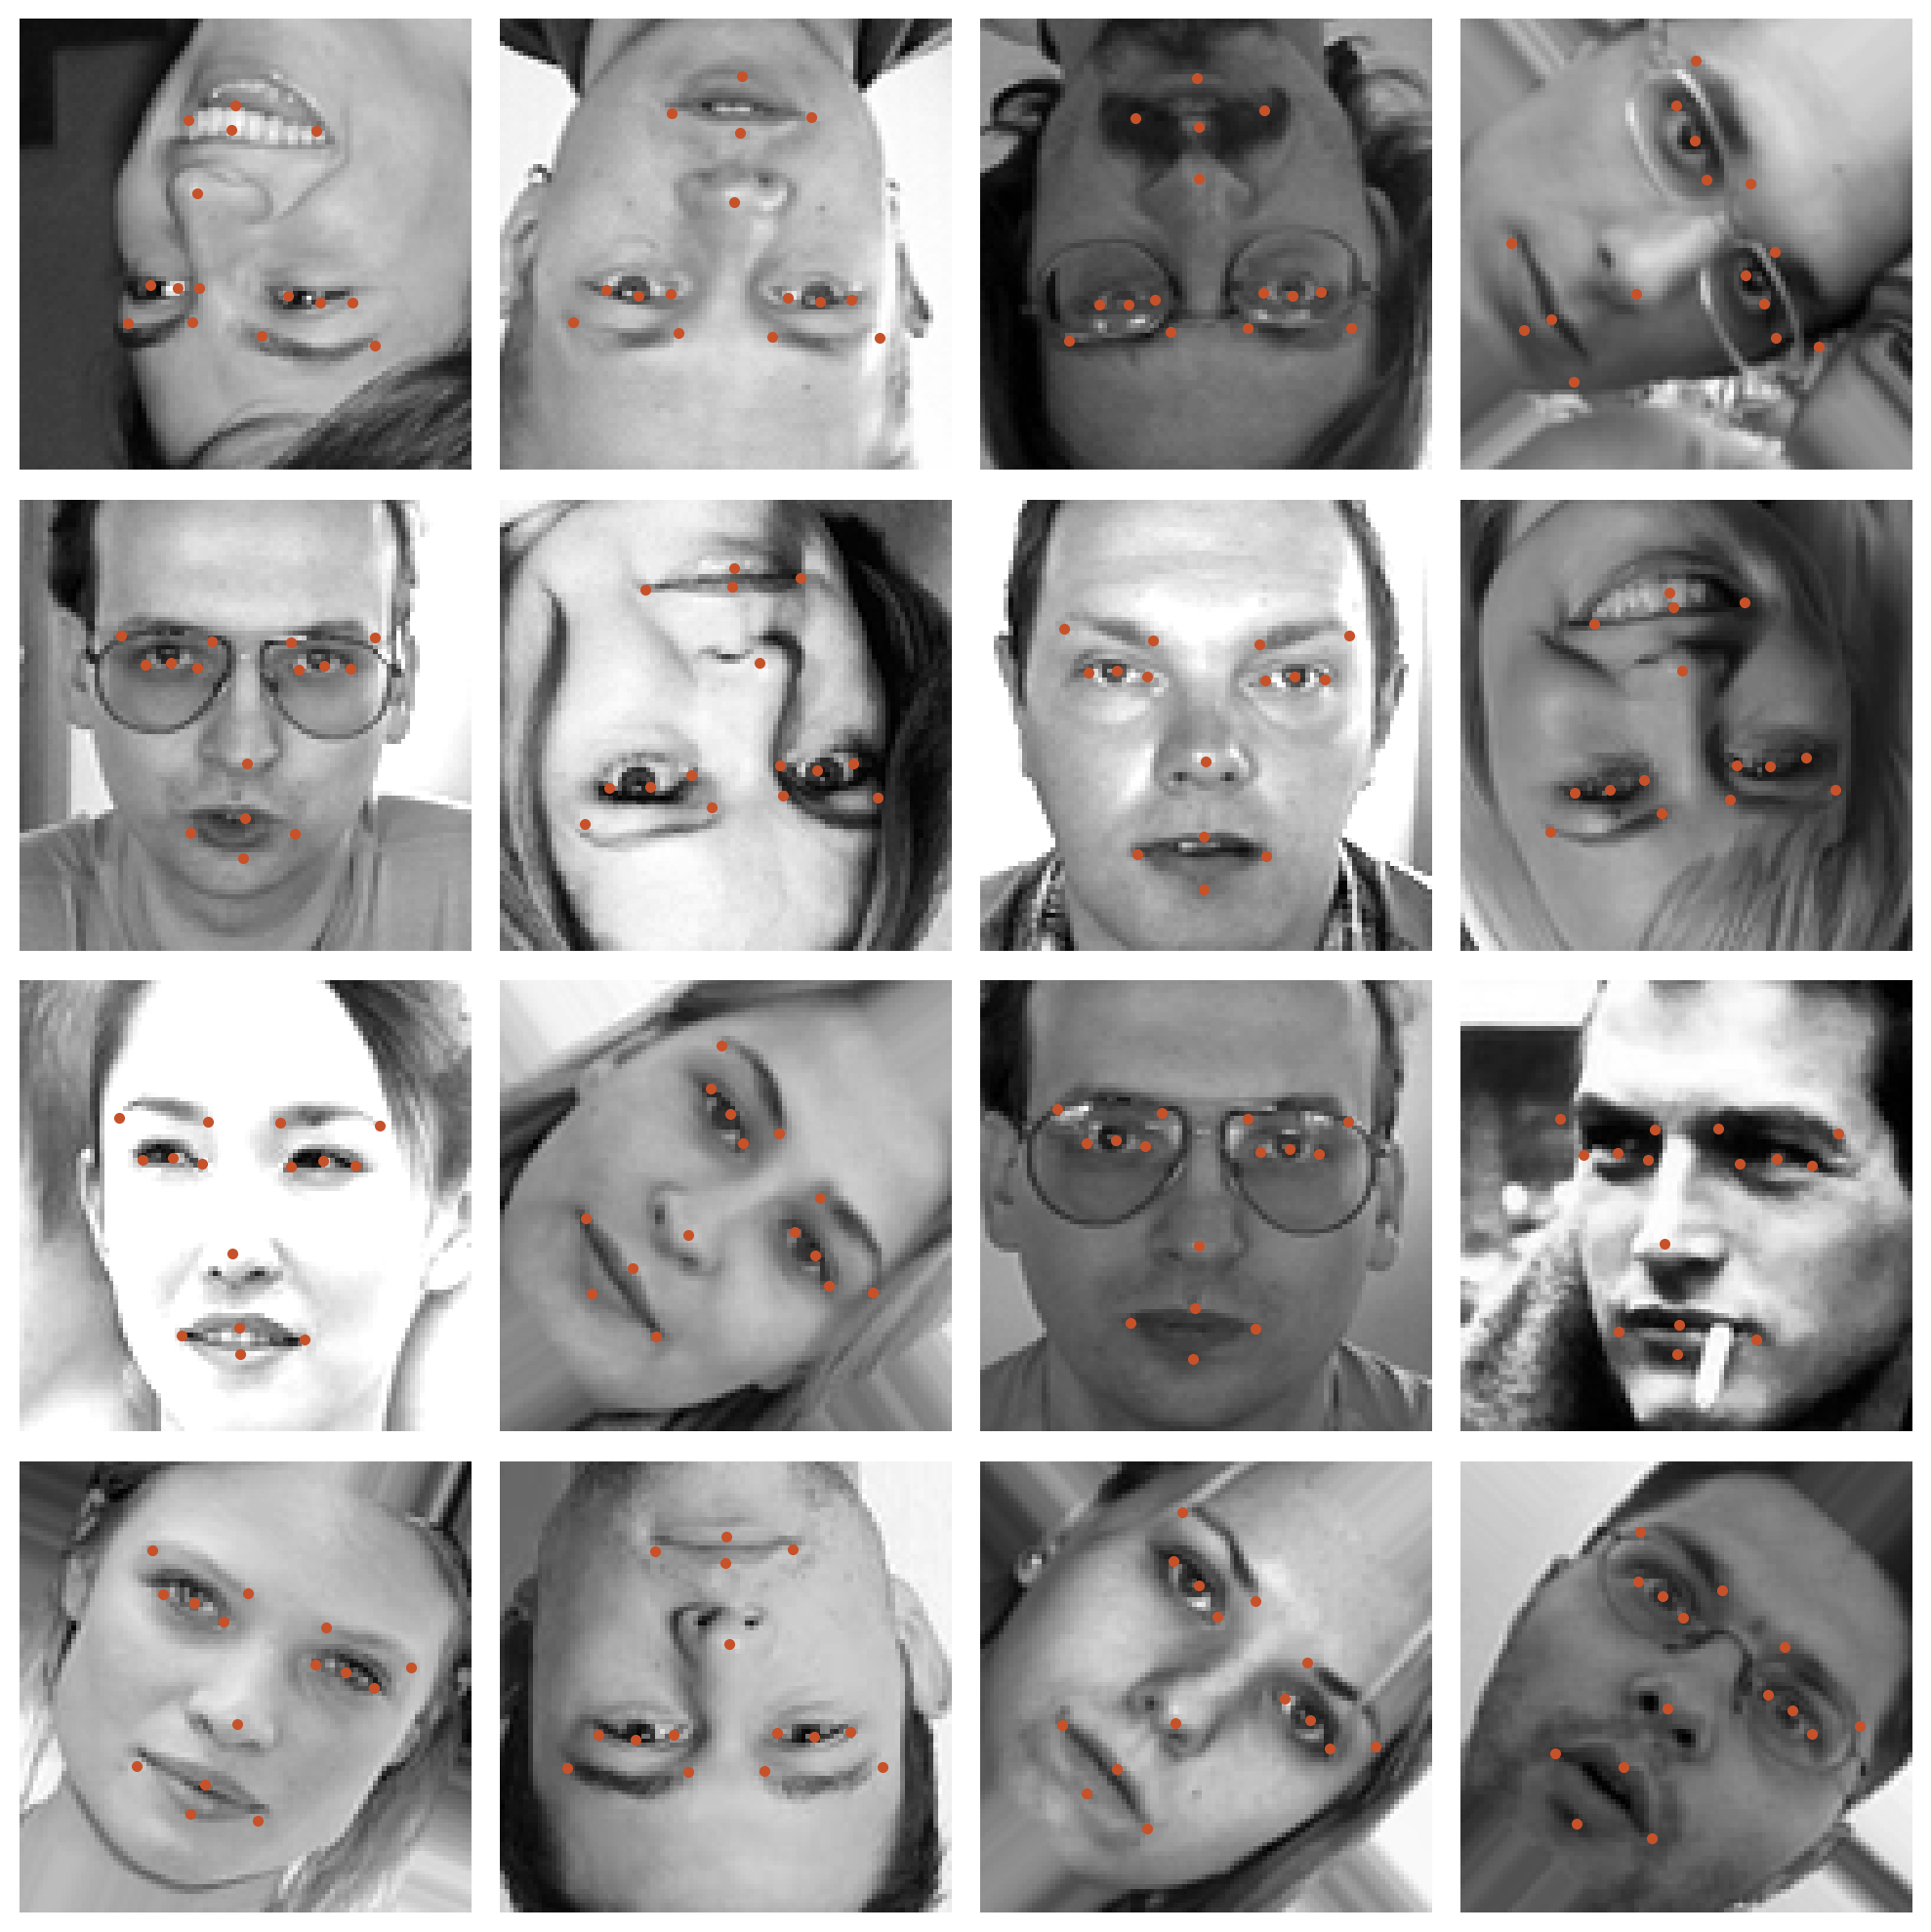

In [45]:
# @title Printing out samples of predictions
fig, axes = plt.subplots(4,4, figsize=(10,10))
axes = axes.ravel()

out_path = "docs/pics/kp_train_pred_grid.png"

for i in range(16):
  axes[i].imshow(X_test_kp[i].reshape(96,96), cmap='gray')
  axes[i].axis('off')
  for j in range(1,31,2):
      axes[i].plot(predicted_kp.iloc[i,j-1],predicted_kp.iloc[i,j], marker='.', color=kp_color)


fig.tight_layout()
fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
plt.close(fig)

display(Image(filename=out_path))


# Part 2. Facial Expression detection

In this second part of the project, I train the second model which will classify emotions. The data contains images that belong to 5 categories:

* 0 = Angry
* 1 = Disgust
* 2 = Sad
* 3 = Happy
* 4 = Surprise

The images in the data set are of size 48px * 48px. Therefore they need to be resized so that we can run the Expression detection model with the Key facial point detection model together.


In [42]:
#HIDE
# @title Loading and reshaping data

# Facial expresion csv data load
expression_df = pd.read_csv("Data/icml_face_data.csv")
expression_df.head()
#expression_df[' pixels'][0] # string
#expression_df.isnull().sum()

# Function to convert pixel values from string format to array format
def string_to_array(x):
  return np.array(x.split(' ')).reshape(48,48,1).astype('float32')

# Function to resize the images from (48,48) to (96,96)
def resize(x):
  img = x.reshape(48,48)
  return cv2.resize(img, (96,96), interpolation = cv2.INTER_CUBIC)

expression_df[' pixels'] = expression_df[' pixels'].apply(lambda x: string_to_array(x))
expr_1 = expression_df[' pixels'][0]
expression_df[' pixels'] = expression_df[' pixels'].apply(lambda x: resize(x))

# Create the labels for the data
label_to_text = {0:'Angry', 1:'Disgusted', 2:'Sad', 3:'Happy', 4:'Surprised'}


Below is an example of an original image, results from resizing and final image after interpolation.

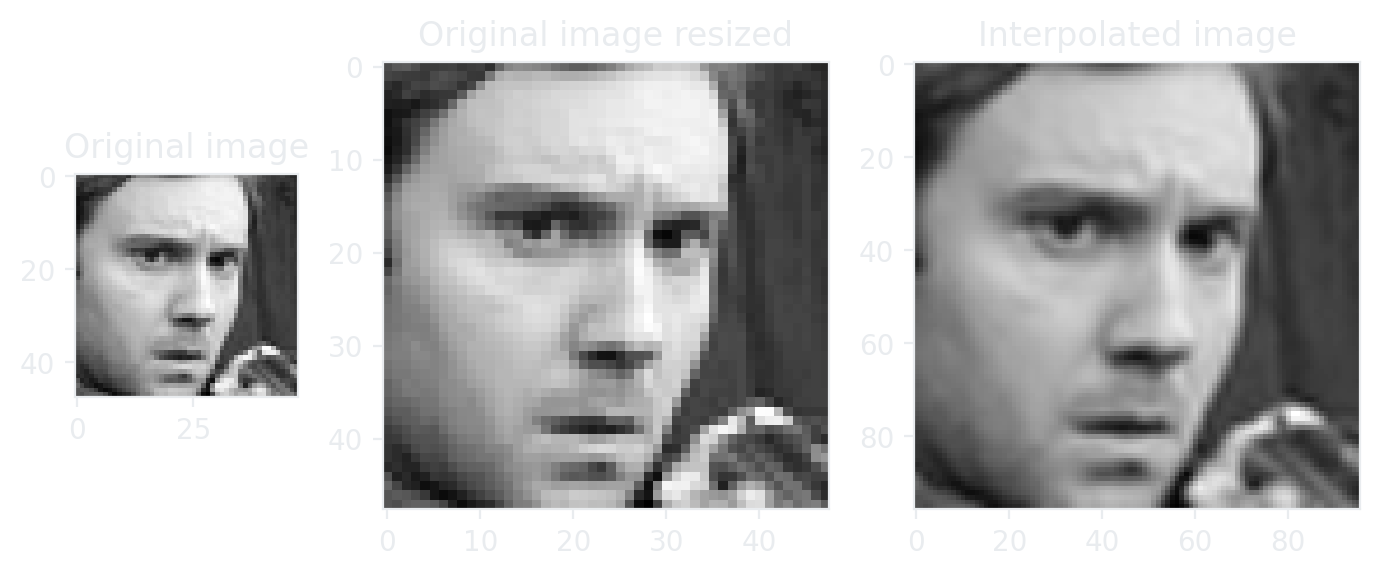

In [44]:
#HIDE
# @title Plotting the first image after reshaping


out_path = "docs/pics/reshaping_imgs.png"

orig_height, orig_width = expr_1.shape[:2]
resized_height, resized_width = expression_df[' pixels'][0].shape[:2]

# Calculate subplot width ratios based on image widths
width_ratio = orig_width / resized_width

# Create subplots with adjusted width ratios
fig, axes = plt.subplots(1, 3, figsize=(7, 5), gridspec_kw={'width_ratios': [width_ratio, 1, 1]})

# Display the original image
axes[0].imshow(expr_1, cmap='gray')
axes[0].set_title('Original image')
axes[0].set_aspect('equal')

# Display the original image (expr_1)
axes[1].imshow(expr_1, cmap='gray')
axes[1].set_title('Original image resized')
axes[1].set_aspect('equal')

# Display the resized image
axes[2].imshow(expression_df[' pixels'][0], cmap='gray')
axes[2].set_title('Interpolated image')
axes[2].set_aspect('equal')


fig.tight_layout()
fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
plt.close(fig)

display(Image(filename=out_path))


### Visualising the images in the dataset with the emotions


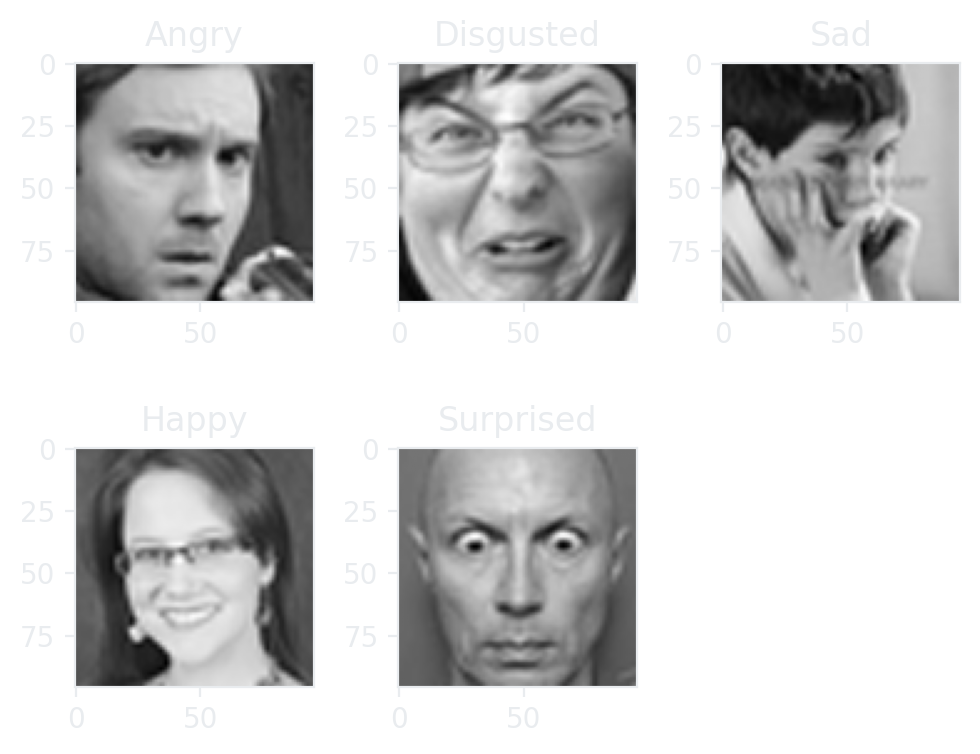

In [47]:
#HIDE
# @title Plotting images with labels

out_path = "docs/pics/labeled_imgs.png"

emotions = [0, 1, 2, 3, 4]
fig, axes = plt.subplots(2, 3, figsize=(5, 4))  # 1 row, 5 columns
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i in emotions:
  data = expression_df[expression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96,96)
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(label_to_text[i])

for i in range(len(emotions), len(axes)):  # Start from the 65th subplot
    axes[i].axis('off')



fig.tight_layout()
fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
plt.close(fig)

display(Image(filename=out_path))

In [70]:
#HIDE
expression_df.head()

Below is the counts of each emotion category. Our data is extremely unbalanced with very few images portraying disgust and many images within category happy.

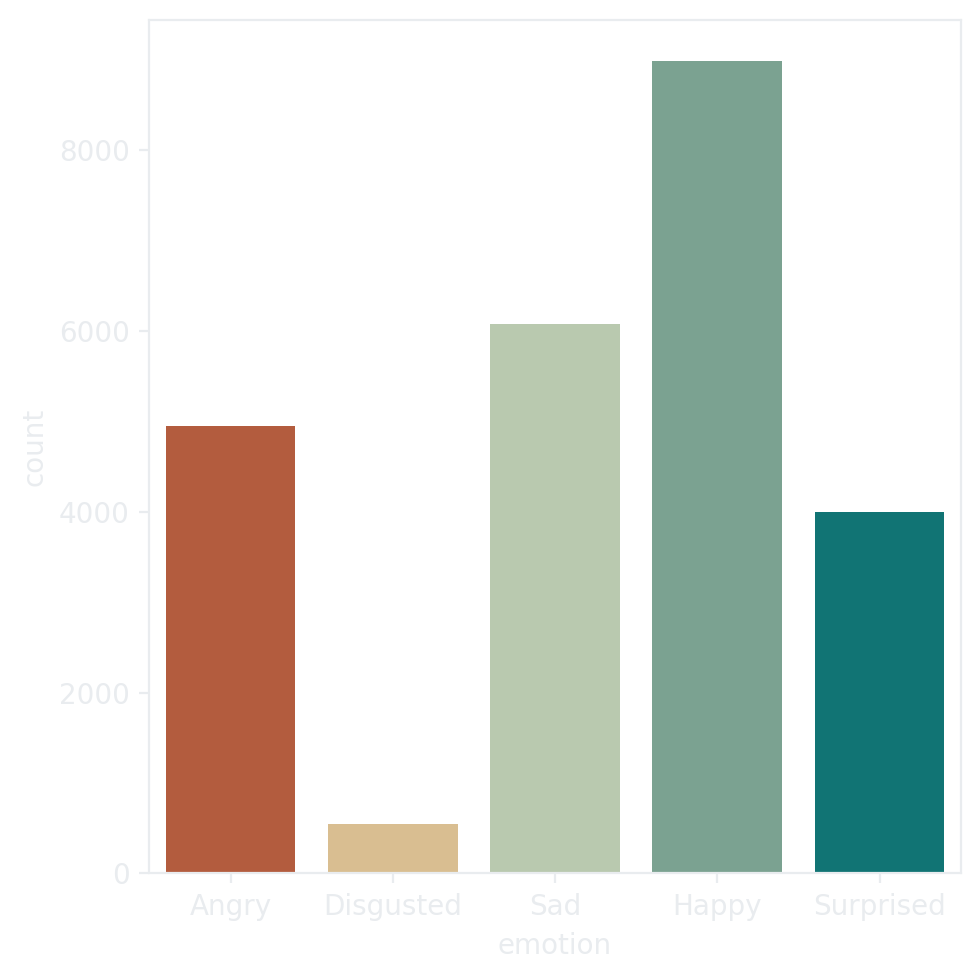

In [50]:
#HIDE
# @title Plotting emotions present in bar plot
fig = plt.figure(figsize=(5,5))
sns.countplot(x='emotion', data=expression_df, palette=[palette[0], palette[1], palette[4], palette[5], palette[6]], hue='emotion', legend=False)
plt.xticks(ticks=emotions, labels=[label_to_text[emotion] for emotion in emotions]) #If you also want to change xticks to the labels in label_to_text

fig.tight_layout()


out_path = "docs/pics/emotion_bars.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
plt.close(fig)

display(Image(filename=out_path, width=460))

### Data preparation and image augmentation

In [51]:
#HIDE
# @title Splitting dataframe to features and labels and test set

X_ed = expression_df[' pixels']
y_ed = to_categorical(expression_df['emotion'])

X_ed = np.stack(X_ed, axis=0)
X_ed = X_ed.reshape(24568, 96,96,1)

print("X shape", X_ed.shape)
print("y shape", y_ed.shape)

X_train_ed, X_test_ed, y_train_ed, y_test_ed = \
    train_test_split(X_ed, y_ed, test_size=0.1, shuffle = True, random_state=42)
X_val_ed, X_test_ed, y_val_ed, y_test_ed = train_test_split(X_test_ed, \
                y_test_ed, test_size=0.5, shuffle = True, random_state=42)

print("X train shape", X_train_ed.shape)
print("y train shape", y_train_ed.shape)
print("X val shape", X_val_ed.shape)
print("y val shape", y_val_ed.shape)
print("X test shape", X_test_ed.shape)
print("y test shape", y_test_ed.shape)

X shape (24568, 96, 96, 1)
y shape (24568, 5)
X train shape (22111, 96, 96, 1)
y train shape (22111, 5)
X val shape (1228, 96, 96, 1)
y val shape (1228, 5)
X test shape (1229, 96, 96, 1)
y test shape (1229, 5)


### Data preprocessing

In the data preprocessing I will again normalize the data and perform image augmentation, as was done in the Part 1. of the project.

First, I normalize the data to conatin values between 0 and 1. Then, I use the following image augmentation techniques:

1.   rotating up to 15 degrees
2.   shifting the image horisontally up to 0.1*image width
3.   shifting the image vertically up to 0.1*image height
4.   shearing the image up to 0.1
5.   zooming the image up to 10 %
6.   horisontally flipping the image
7.   vertically flipping the image
8.   Adjusting the brightness

The spaces outside the boundaries are filled by replicting the nearest pixels.




In [52]:
#HIDE
# @title Data preprocessing

#Normalisation
X_train_ed = X_train_ed/255
X_val_ed = X_val_ed/255
X_test_ed = X_test_ed/255


### Build and train Deep Learning model for facial expression classification

The model I will build has the following architecture:

In [82]:
#HIDE
# @title Emotion detection model architecture
%%capture

dot = Digraph(comment='Final model architecture', format='svg')

# Arrange subgraphs up to down
dot.attr(size='3.5,9',rankdir='UD'
        )
dot.attr('node', shape='box', fontsize='12', margin='0.2,0.2')

###############################################################################
# Emotion detection model
###############################################################################
with dot.subgraph(name='cluster_final_model') as c:
    c.attr(label='Emotion Detection model', style='filled', color='lightblue', nodesep='0.3', ranksep='0.3')

    c.node('input', 'INPUT', shape='box')
    c.node('zeropad', 'Zero padding', shape='box')
    c.node('conv2d', 'Conv2D', shape='box')
    c.node('bn_relu', 'BatchNorm, ReLU', shape='box')
    c.node('pool', 'MaxPool2D', shape='box')
    c.node('Res1', 'Res-block', shape='box', style='filled', fillcolor='lightgray')
    c.node('Res2', 'Res-block', shape='box', style='filled', fillcolor='lightgray')
    c.node('Avgpool', 'AveragePooling2D', shape='box')
    c.node('flatten', 'Flatten()', shape='box')
    c.node('dense1', 'Dense, ReLU, Dropout', shape='box')
    c.node('output', 'OUTPUT', shape='box')

    # Connect them
    c.edge('input', 'zeropad')
    c.edge('zeropad', 'conv2d')
    c.edge('conv2d', 'bn_relu')
    c.edge('bn_relu', 'pool')
    c.edge('pool', 'Res1')
    c.edge('Res1', 'Res2')
    c.edge('Res2', 'Avgpool')
    c.edge('Avgpool', 'flatten')
    c.edge('flatten', 'dense1')
    c.edge('dense1', 'output')


# Render diagram (outputs two files: .gv source and .svg image)
dot.render('docs/pics/emotion_model_architecture', view=True)


In [83]:
#HIDE
from IPython.display import HTML

# Display the SVG content as HTML
with open('docs/pics/final_model_architecture.svg', 'r') as f:
    svg_content = f.read()
display(HTML(svg_content))

In [53]:
# @title Emotion recognition model

input_shape = (96,96,1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# Stage 1
X = Conv2D(64, (7,7), strides = (2,2), name = 'conv1', kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(axis = 3, name = 'bn1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides = (2,2))(X)

# Stage 2
X = res_block(X, filter = [64,64,256], stage = 'res2')

# Stage 3
X = res_block(X, filter = [128,128,512], stage = 'res3')

# Stage 4 (optional)
#X = res_block(X, filter= [256,256,1024], stage = 'res4')

# Average pooling
X = AveragePooling2D((4,4), name = 'avg_pool')(X)

# Final layer
X = Flatten()(X)
X  = Dense(5, activation = 'softmax', name = 'dense', kernel_initializer=glorot_uniform(seed=0))(X)

Emotion_det_model_2 = Model(inputs = X_input, outputs = X, name = 'Resnet18')


In [54]:
#HIDE
dot_path, svg_path, png_path, type_to_color = export_colored_model_graph(
    model=Emotion_det_model_2,
    image_base=image_base,
    stem="model_arch",
    type_color_map= palette_hex,
    show_shapes=True,
    rankdir="TB",
    edge_color="#8ECAE6",
    bg_color="white",
    border_width=1,
    display_svg=True,
)


In [85]:
#HIDE
# @title Image Augmentation

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode = "nearest"
)

In [87]:
#HIDE
# @title Training emotion detection model for 100 epochs


adam = tf.keras.optimizers.Adam(learning_rate = 0.0001,
                                  beta_1 = 0.9, \
                                  beta_2 = 0.999,
                                  amsgrad = False)

if retrain_model:

  train_generator = train_datagen.flow(
      X_train_ed,
      y_train_ed,
      batch_size=64
  )

  Emotion_det_model_2.compile(optimizer = adam,
                        loss = "categorical_crossentropy",
                        metrics = ["accuracy"])


  # Callbacks: logs epoch results to CSV
  csv_logger = CSVLogger(
      'Models/training_history_model_16-12-2025.csv',
      append=True,         # keep adding if file exists
      separator=','        # comma-separated
  )


  # Callbacks: reduce lr on plateau
  reduce_lr = ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.65,
      patience=5,
      min_lr=1e-7,
      verbose=1
  )

  # Callbacks: early stopping
  earlystopping = EarlyStopping(
      monitor = 'val_loss',
      mode = 'min',
      verbose = 1,
      patience =10
  )

  # Callbacks:save best model
  checkpointer = ModelCheckpoint(
      filepath = "Models/Emotion_det_model_16-12-2025.keras",
      verbose = 1,
      save_best_only = True
  )

  history = Emotion_det_model_2.fit(
      train_generator,
      epochs = 100,
      validation_data = (X_val_ed, y_val_ed),
      callbacks = [checkpointer, earlystopping, reduce_lr, csv_logger])

Epoch 1/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3861 - loss: 1.4138
Epoch 1: val_loss improved from inf to 1.41906, saving model to Models/Emotion_det_model_16-12-2025.keras
346/346 ━━━━━━━━━━━━━━━━━━━━ 60s 111ms/step - accuracy: 0.3861 - loss: 1.4138 - val_accuracy: 0.3510 - val_loss: 1.4191 - learning_rate: 1.0000e-04
Epoch 2/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4018 - loss: 1.3722
Epoch 2: val_loss did not improve from 1.41906
346/346 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.4018 - loss: 1.3722 - val_accuracy: 0.3420 - val_loss: 1.5051 - learning_rate: 1.0000e-04
Epoch 3/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4280 - loss: 1.3311
Epoch 3: val_loss did not improve from 1.41906
346/346 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.4280 - loss: 1.3311 - val_accuracy: 0.3428 - val_loss: 1.4884 - learning_rate: 1.0000e-04
Epoch 4/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4427 - loss: 1.3050
Epoch 

In [ ]:
#HIDE
print(f"Training samples: {len(X_train_ed)}")
print(f"Batch size: {64}")
steps_per_epoch=np.ceil(len(X_train_ed) / 64).astype(int)
print(f"Steps per epoch: {steps_per_epoch}")


Training samples: 22111
Batch size: 64
Steps per epoch: 346


In [55]:
#HIDE
# @title Load the emotion detection history from csv
# read the CSV into a DataFrame

# Load data and automatically convert all numeric columns
df_his = pd.read_csv(
    "Models/training_history_model_16-12-2025.csv",
    sep=',',
    engine='python'
).apply(pd.to_numeric, errors='coerce')

# Convert DataFrame to Keras-like history dictionary
history = df_his.to_dict(orient="list")

#print(history.keys())

In [59]:
#HIDE
out_path = "docs/pics/emotion_model_training_history.png"
# Plot the training history
retrain_model = True
if retrain_model:
  fig = plt.figure(figsize=(7,5))
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Emotion Detection Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train_loss','val_loss'], loc = 'upper right')
  fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
  plt.close(fig)

display(Image(filename=out_path, width=460))

In [65]:
#HIDE
# load the model architecture f = final

Emotion_det_model_2 = tf.keras.models.load_model("Models/Emotion_det_model_16-12-2025.keras")
Emotion_det_model_2.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = ["accuracy"])

### Evaluate model
Confusion matrix, accuracy, precision, and recall


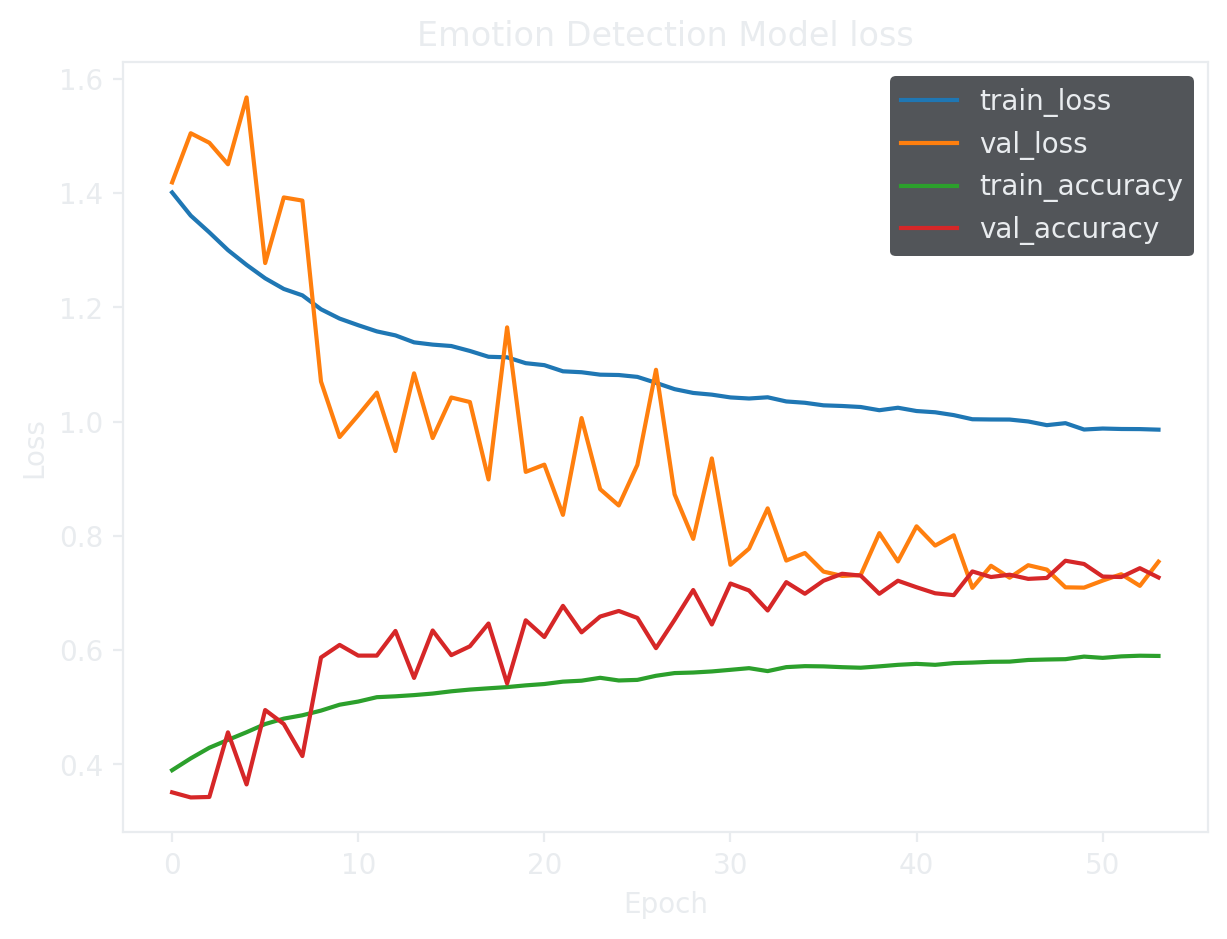

In [60]:
#HIDE
# Plot the training history

out_path = "docs/pics/emotion_model_training_history2.png"

fig = plt.figure(figsize=(7,5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Emotion Detection Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','val_loss','train_accuracy','val_accuracy'], loc = 'upper right')

fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
plt.close(fig)
display(Image(filename=out_path, width=460))

In [66]:
#HIDE
result = Emotion_det_model_2.evaluate(X_test_ed, y_test_ed)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7671 - loss: 0.6242


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


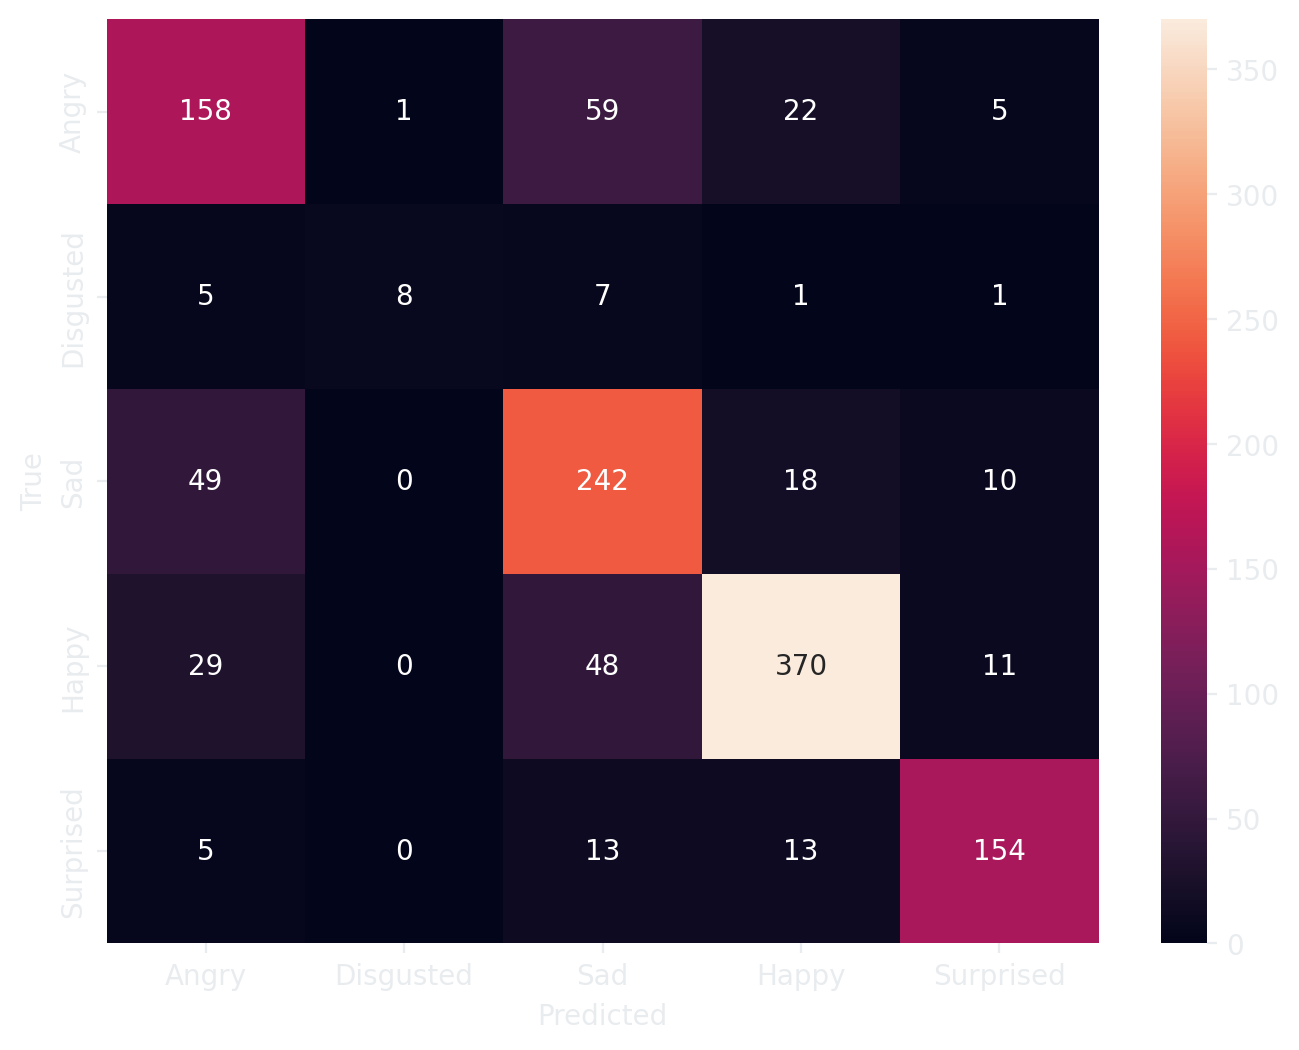

In [67]:
#HIDE

out_path = "docs/pics/emotion_model_cmat.png"

predicted_classes = np.argmax(Emotion_det_model_2.predict(X_test_ed), axis=1)
true_classes = np.argmax(y_test_ed, axis=1)

# Create a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
fig = plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_to_text.values(), yticklabels=label_to_text.values())
plt.xlabel('Predicted')
plt.ylabel('True')


fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
plt.close(fig)
display(Image(filename=out_path))


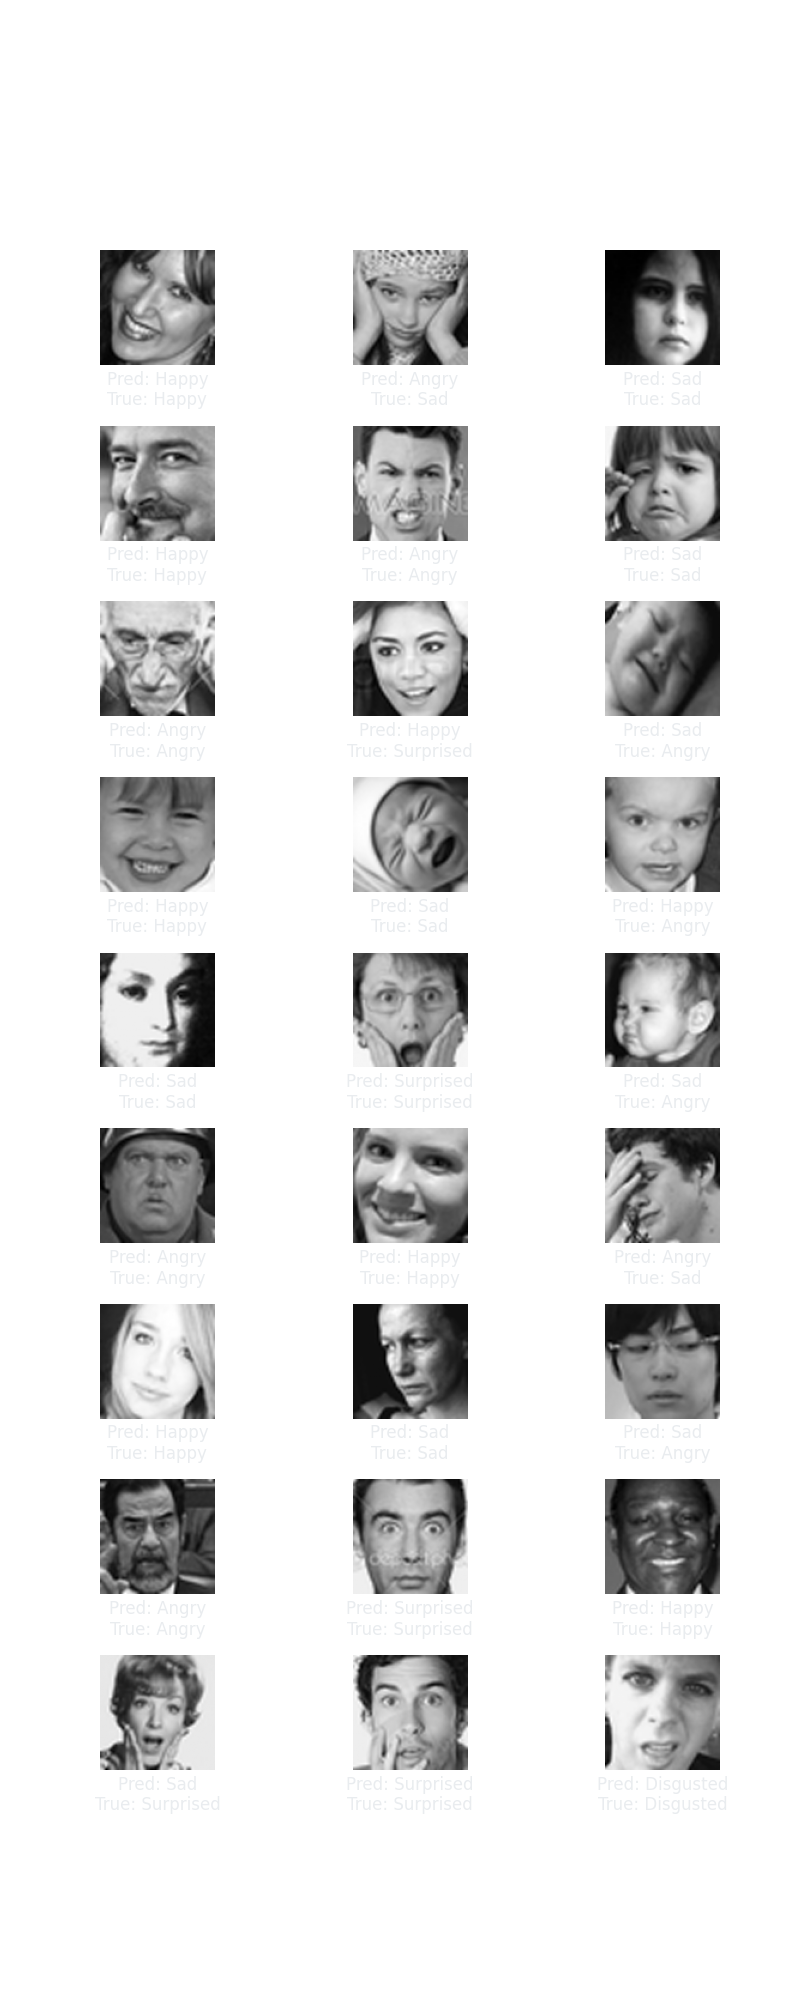

In [95]:
#HIDE
# @title Plotting images with true and predicted labels
out_path = "docs/pics/emotion_pred_vs_real.png"
# Assuming expression_df contains a column 'pixels' with images and 'emotion' labels
L = 9
W = 3
num_images = L*W  # Number of images to randomly select

fig, axes = plt.subplots(L, W, figsize=(8, 20))
axes = axes.ravel()  # Flatten the axes array for easy indexing

for i in np.arange(0, num_images):
  axes[i].imshow(X_test_ed[i].reshape(96,96), cmap='gray')
  # Put text BELOW the image
  axes[i].text(
      0.5, -0.05,
      f"Pred: {label_to_text[predicted_classes[i]]}\nTrue: {label_to_text[true_classes[i]]}",
      transform=axes[i].transAxes,
      ha="center", va="top",
      color="#e9ecef", fontsize=12
  )
  axes[i].axis('off')

# ✅ increase spacing between images
fig.subplots_adjust(hspace=0.3, wspace=1.2)

fig.savefig(out_path,transparent=True)
plt.close(fig)
display(Image(filename=out_path))

In [97]:
#HIDE
print("Classification report for emotion detection model:")
print(classification_report(true_classes, predicted_classes))

Classification report for emotion detection model:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       245
           1       0.89      0.36      0.52        22
           2       0.66      0.76      0.70       319
           3       0.87      0.81      0.84       458
           4       0.85      0.83      0.84       185

    accuracy                           0.76      1229
   macro avg       0.78      0.68      0.71      1229
weighted avg       0.77      0.76      0.76      1229



The above table tells us that the classes where we had the least data (# support) have the weakest performance. Precision (percentage of samples predicted to be class x that are actually x) and recall (percentage of x samples in data that are correctly labeled as x) are highest in class 3 where we also had the most samples. f1 -score is the harmonic mean of precision and recall and it is calculated as

$F_1 = \frac{\text{precision} \ \times \ \text{recall}}{\text{precision} \ +\ \text{recall}}$

# Part 3. Combining the key point detection and facial expression recognition models



In [98]:
#HIDE

def predict(X_test):
# Predicting the keypoints
  df_predict = model_1_facialKeyPoints.predict(X_test)

# Predicting the emotion
  df_emotion = np.argmax(Emotion_det_model_2.predict(X_test), axis = -1)

# Rehaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

# Converting the predictions into a dataframe
  df_predict = pd.DataFrame(df_predict, columns=columns)

# Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [99]:
#HIDE
df_predict = predict(X_test_ed)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [103]:
#HIDE
df_predict.head()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          64.648270          39.462273           35.029705   
1          67.049782          37.382389           30.436636   
2          64.116463          36.904625           34.684856   
3          63.984192          36.043690           27.817284   
4          63.373016          40.186924           29.947830   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           27.303909                57.424828                38.391609   
1           31.989122                59.316116                38.093258   
2           35.691677                57.599121                37.935898   
3           38.471413                54.756351                37.784523   
4           38.409580                56.042046                41.237423   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                71.964722                43.019527                 41.132412   
1                74.362892                38.955746                 37.369408   
2                70.917572                37.860672                 40.516914   
3                74.124146                36.159767                 35.542854   
4                70.940956                41.500175                 37.221470   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 31.116213  ...   52.116562            51.100479   
1                 34.813652  ...   60.451092            57.179199   
2                 37.410923  ...   59.986973            58.181126   
3                 38.942562  ...   52.165367            71.062103   
4                 40.498299  ...   60.592480            60.439510   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            69.342575             22.495335             57.190903   
1            80.493698             28.356564             76.011620   
2            76.441887             33.698921             75.366005   
3            59.365967             28.763102             60.063107   
4            77.742844             29.692043             76.036491   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               35.552544               63.602200                  34.299168   
1               42.261841               78.572998                  41.904636   
2               46.023739               74.968422                  45.919083   
3               46.585697               60.998100                  47.175484   
4               45.099701               77.343796                  45.182957   

   mouth_center_bottom_lip_y  emotion  
0                  67.525764        3  
1                  82.303894        2  
2                  78.991425        2  
3                  65.630623        3  
4                  79.698212        0  

[5 rows x 31 columns]

Plotting test images of the combined models.

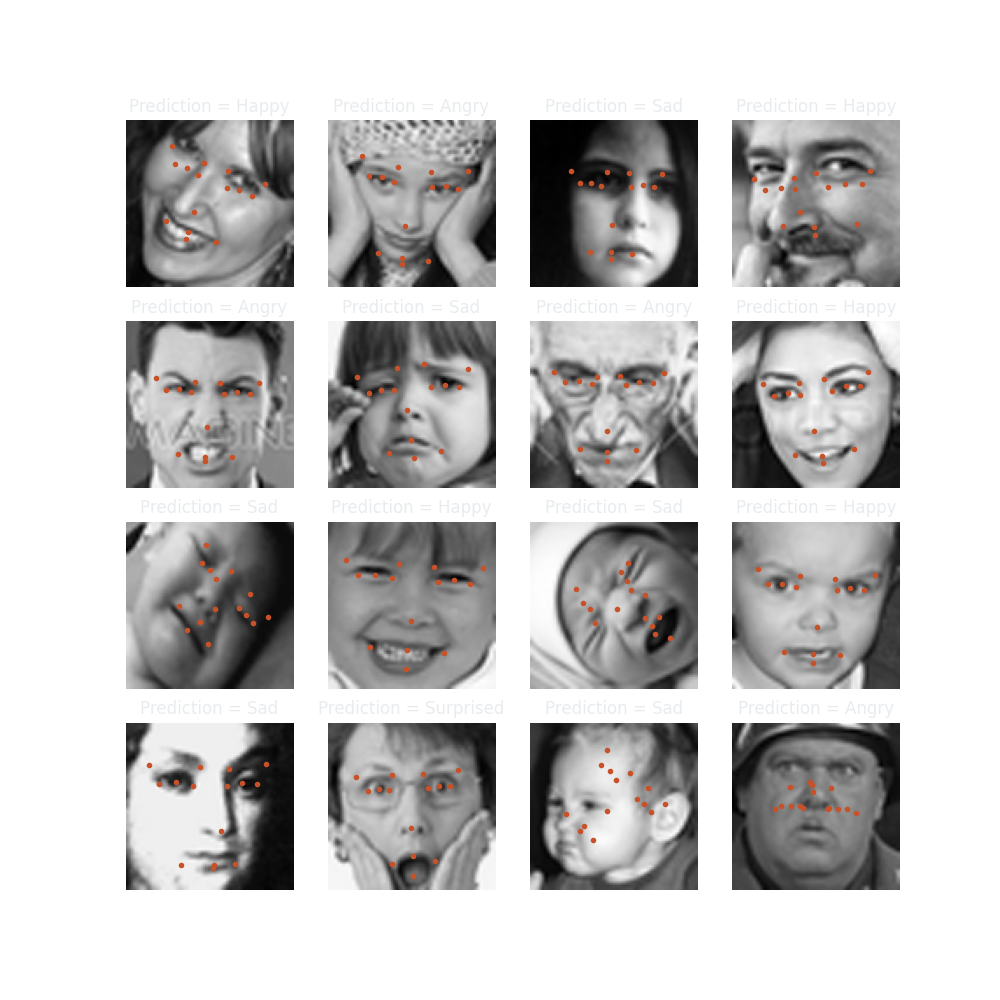

In [100]:
#HIDE
# Plotting the test images and their predicted keypoints and emotions

out_path = "docs/pics/preds_with_both_models.png"

fig, axes = plt.subplots(4,4, figsize=(10,10))
axes = axes.ravel()

for i in range(16):
  axes[i].imshow(X_test_ed[i].reshape(96,96), cmap='gray')
  axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
  axes[i].axis('off')
  for j in range(1,31,2):
      axes[i].plot(df_predict.iloc[i,j-1],df_predict.iloc[i,j], marker='.', color=kp_color)


fig.savefig(out_path,transparent=True)
plt.close(fig)
display(Image(filename=out_path))

In [167]:
#HIDE
push_git=True
# @title GIT commands
# Add changes
if push_git:
  !git add .

In [168]:
#HIDE
# Commit changes and remember to change commit message
if push_git:
  !git commit -m "updated to dark theme" #Remember to change commit message

[main 2c2b9bd] updated to dark theme
 6 files changed, 349 insertions(+), 144 deletions(-)
 create mode 100644 docs/pics/emotion_bars.png
 create mode 100644 docs/pics/emotion_model_training_history.png
 create mode 100644 docs/pics/kp_train_history.png


In [169]:
#HIDE
# Push changes
if push_git:
  with open('/content/drive/MyDrive/tokens/token1.txt', 'r') as f:
      token = f.read().strip()

  !git push --force https://$token@github.com/KaisuH/Emotion-AI.git

Enumerating objects: 16, done.
Counting objects: 100% (16/16), done.
Delta compression using up to 12 threads
Compressing objects: 100% (10/10), done.
Writing objects: 100% (10/10), 533.21 KiB | 1.49 MiB/s, done.
Total 10 (delta 6), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
To https://github.com/KaisuH/Emotion-AI.git
   aa1164f..2c2b9bd  main -> main


In [ ]:
#HIDE
make_new_branch = False
if make_new_branch:
  # 1. Create a brand-new “orphan” branch (no history)
  !git checkout --orphan clean-start

  # 2. Stage everything in your current working directory
  !git add -A

  # 3. Commit it as your one “fresh start” commit
  !git commit -m "Fresh start: keep only current work"

  # 4. Force-push this new branch to overwrite remote main
  !git push https://$token@github.com/KaisuH/Emotion-AI.git clean-start:main --force

  # 5. (Optional) Switch back to ‘main’ locally and delete the temp branch
  !git checkout main
  !git branch -D clean-start

In [101]:
#HIDE
# @title Producing the final file
%%capture
import nbformat

nb_name = "Emotion_AI.ipynb"        # original notebook
out_nb_name = "Emotion_AI_tagged.ipynb"  # new notebook with tags

nb = nbformat.read(nb_name, as_version=4)

for cell in nb.cells:
    if cell.cell_type == 'code':
        # Check if the first line of the cell source is #HIDE
        first_line = cell.source.strip().split('\n',1)[0]
        if first_line.strip().startswith('#HIDE'):
            cell.metadata.setdefault('tags', []).append('hide_input')
nbformat.write(nb, out_nb_name)

In [165]:
#HIDE
%%capture
#Run this code to generate the tagged file
%%writefile hide_code_config.json
{
  "TagRemovePreprocessor": {
    "enabled": true,
    "remove_input_tags": ["hide_input"]
  },
  "Exporter": {
    "exclude_input_prompt": true,
    "exclude_output_prompt": true
  }
}

In [166]:
#HIDE
%%capture
# 1) Convert notebook -> docs/index.html
!jupyter nbconvert --to html --config hide_code_config.json \
    --output "docs/index.html" "Emotion_AI_tagged.ipynb"

import re
from pathlib import Path

# -----------------------------
# Settings
# -----------------------------
TITLE = "Brain tumor detector"

docs_dir = Path("docs")
html_path = docs_dir / "index.html"

# Assets are NOW in docs/ (same folder as index.html)
bootstrap_file = docs_dir / "bootstrap.min.css"
navbar_file    = docs_dir / "navbar.html"

bootstrap_href = "bootstrap.min.css"  # relative to docs/index.html

# -----------------------------
# Sanity checks
# -----------------------------
if not html_path.exists():
    raise FileNotFoundError("docs/index.html not found (nbconvert failed?)")
if not bootstrap_file.exists():
    raise FileNotFoundError("docs/bootstrap.min.css not found")
if not navbar_file.exists():
    raise FileNotFoundError("docs/navbar.html not found")

# -----------------------------
# Read generated HTML
# -----------------------------
html = html_path.read_text(encoding="utf-8")

def remove_block(text: str, start_marker: str, end_marker: str) -> str:
    return re.sub(re.escape(start_marker) + r".*?" + re.escape(end_marker),
                  "", text, flags=re.DOTALL)

# -----------------------------
# Title (robust)
# -----------------------------
html = re.sub(r"<title>.*?</title>", f"<title>{TITLE}</title>", html, count=1,
              flags=re.IGNORECASE | re.DOTALL)

# -----------------------------
# Bootstrap CSS link (idempotent)
# -----------------------------
BOOT_START = "<!-- BOOTSTRAP LINK START -->"
BOOT_END   = "<!-- BOOTSTRAP LINK END -->"
html = remove_block(html, BOOT_START, BOOT_END)

bootstrap_link_block = f"""{BOOT_START}
<link rel="stylesheet" href="{bootstrap_href}">
{BOOT_END}
"""
html = re.sub(r"</head>", bootstrap_link_block + "\n</head>", html, count=1, flags=re.IGNORECASE)

# -----------------------------
# Navbar injection:
# - put ALL <style>...</style> from navbar.html into <head>
# - put ONLY <nav>...</nav> into <body>
# -----------------------------
navbar_raw = navbar_file.read_text(encoding="utf-8")

NAVSTYLE_START = "<!-- NAVBAR STYLES START -->"
NAVSTYLE_END   = "<!-- NAVBAR STYLES END -->"
NAV_START      = "<!-- NAVBAR START -->"
NAV_END        = "<!-- NAVBAR END -->"

html = remove_block(html, NAVSTYLE_START, NAVSTYLE_END)
html = remove_block(html, NAV_START, NAV_END)

# Extract styles
navbar_styles = "\n".join(
    re.findall(r"<style[\s\S]*?</style>", navbar_raw, flags=re.IGNORECASE)
).strip()

if navbar_styles:
    html = re.sub(
        r"</head>",
        f"{NAVSTYLE_START}\n{navbar_styles}\n{NAVSTYLE_END}\n</head>",
        html,
        count=1,
        flags=re.IGNORECASE
    )

# Extract nav
nav_match = re.search(r"<nav[\s\S]*?</nav>", navbar_raw, flags=re.IGNORECASE)
if not nav_match:
    raise ValueError("Could not find a <nav>...</nav> block inside docs/navbar.html")

navbar_nav = nav_match.group(0).strip()

# Insert navbar right after opening <body ...>
html = re.sub(
    r"(<body[^>]*>)",
    r"\1\n" + f"{NAV_START}\n{navbar_nav}\n{NAV_END}\n",
    html,
    count=1,
    flags=re.IGNORECASE
)

# -----------------------------
# ✅ CONTENT COLUMN WRAPPER (idempotent)
# This centers ONLY the notebook content AFTER the navbar.
# -----------------------------
COL_START = "<!-- CONTENT COLUMN START -->"
COL_END   = "<!-- CONTENT COLUMN END -->"
html = remove_block(html, COL_START, COL_END)

# Start wrapper right after NAV_END
if NAV_END in html:
    html = html.replace(
        NAV_END,
        NAV_END + f"\n{COL_START}\n<div class=\"content-column\">\n",
        1
    )

# Close wrapper right before </body> (so navbar is NOT inside the column)
html = re.sub(
    r"</body>",
    f"\n</div>\n{COL_END}\n</body>",
    html,
    count=1,
    flags=re.IGNORECASE
)

# -----------------------------
# Dark background + scroll fix (idempotent)
# -----------------------------
DARK_START = "<!-- DARK OVERRIDES START -->"
DARK_END   = "<!-- DARK OVERRIDES END -->"
html = remove_block(html, DARK_START, DARK_END)

dark_css = f"""{DARK_START}
<style>
html, body {{
  background: linear-gradient(360deg, #3a3f44, #272b30, #1b1f24) !important;
  background-attachment: fixed !important;
  margin: 0 !important;
  padding: 0 !important;
  color: #aaa !important;
}}

/* ✅ CENTER COLUMN (affects only what we wrapped) */
.content-column {{
  max-width: 1140px !important;
  margin: 40px auto 0 auto !important;
  padding-left: 15px !important;
  padding-right: 15px !important;
}}

#notebook-container,
.container, .container-fluid,
.jp-Notebook, .jp-NotebookPanel, .jp-NotebookPanel-notebook,
.jp-Cell, .jp-Cell-inputWrapper, .jp-Cell-outputWrapper,
.jp-OutputArea, .jp-OutputArea-output,
.jp-RenderedHTMLCommon, .jp-RenderedText {{
  background: transparent !important;
  color: inherit !important;
}}

/*Make *output* code/text green (prints, tracebacks, etc.) */
.jp-OutputArea pre,
.jp-OutputArea-output pre,
.jp-OutputArea-output,
.jp-OutputArea-output code,
.output pre,
.output code {{color: #66ff66 !important;
}}

 /*Mauve hyperlinks everywhere EXCEPT inside the navbar */
a, a:link, a:visited {{
  color: #993461 !important;
}}
a:hover, a:focus, a:active {{
  color: #993461 !important;
  text-decoration: underline;
}}

/* Don't override navbar link colors */
nav a, .navbar a {{
  color: inherit !important;
  text-decoration: none !important;
}}

.jp-RenderedText pre,
.jp-RenderedHTMLCommon pre,
.jp-Cell .jp-Cell-inputWrapper .CodeMirror-lines,
.jp-Cell .jp-Cell-inputWrapper pre,
pre {{
  white-space: pre !important;
  overflow-x: auto !important;
  max-width: 100% !important;
  display: block !important;
}}
</style>
{DARK_END}
"""
html = re.sub(r"</head>", dark_css + "\n</head>", html, count=1, flags=re.IGNORECASE)

# -----------------------------
# Bootstrap JS for navbar toggler (idempotent)
# -----------------------------
JS_START = "<!-- BOOTSTRAP NAVBAR JS START -->"
JS_END   = "<!-- BOOTSTRAP NAVBAR JS END -->"
html = remove_block(html, JS_START, JS_END)

bootstrap_js = f"""{JS_START}
<script src="https://code.jquery.com/jquery-3.5.1.slim.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/popper.js@1.16.1/dist/umd/popper.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/bootstrap@4.5.2/dist/js/bootstrap.min.js"></script>
{JS_END}
"""
html = re.sub(r"</body>", bootstrap_js + "\n</body>", html, count=1, flags=re.IGNORECASE)

# -----------------------------
# Save
# -----------------------------
html_path.write_text(html, encoding="utf-8")


In [ ]:
#HIDE
%%capture
# Run this line to produce the output
!jupyter nbconvert --to html --config hide_code_config.json \
    --output "docs/index.html" "Emotion_AI_tagged.ipynb"


### Renaming the document to produce a nicer name in web tab ###
# After nbconvert generates the HTML:
with open("docs/index.html", "r") as f:
    html_content = f.read()

# Find and replace the title tag content
new_title = "Emotion AI Project"  # Your desired title
html_content = html_content.replace("<title>Emotion_AI_tagged</title>", f"<title>{new_title}</title>")

# Insert CSS just before </head> to ensure it loads after default styles
style_snippet = """
<style>
/* Force horizontal scroll on wide code cells */
.jp-RenderedText pre,
.jp-RenderedHTMLCommon pre,
.jp-Cell .jp-Cell-inputWrapper .CodeMirror-lines,
.jp-Cell .jp-Cell-inputWrapper pre {
  white-space: pre !important;
  overflow-x: auto !important;
  max-width: 100% !important;
  display: block !important;
}
</style>
"""

# Insert style snippet at the end of <head>, or if you prefer, after <head>:
html_content = html_content.replace(
    "</head>",
    f"{style_snippet}\n</head>"
)

# Save the modified HTML
with open("docs/index.html", "w") as f:
    f.write(html_content)